<a href="https://colab.research.google.com/github/Kulikov17/MLDS_ML/blob/main/HW3/woodenML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Результаты работы также должны появиться в базе данных, так как они будут переданы аналитикам компании. В результате вашей работы в базе должна быть информация от вас в двух таблицах (смотри задание в конце нотубука). Наличие информации о ваших результатах в первой таблице: student_results - блокирующее задание, без его выполнения за домашнее задание ставится 0.

Продуктивной и интересной вам работы!

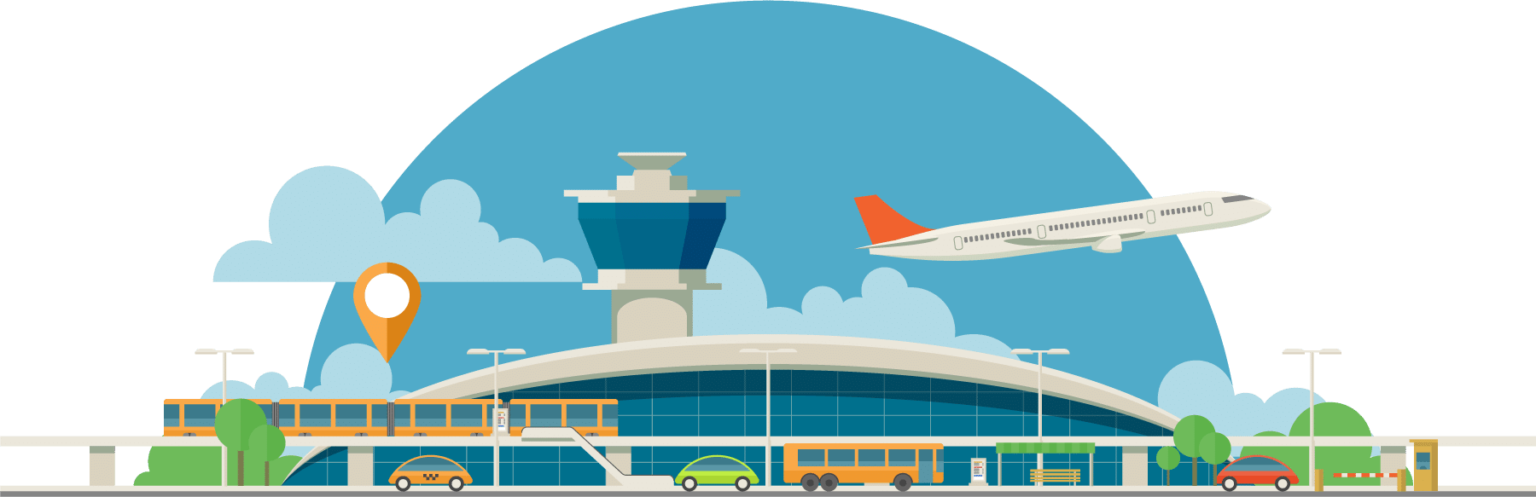

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install eli5
!pip install missingno
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import eli5
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (2.5 балла + 0.25)

## Загрузка и предобработка данных (1.5 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-02-12 15:06:51--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-02-12 15:06:52 (524 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycog2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

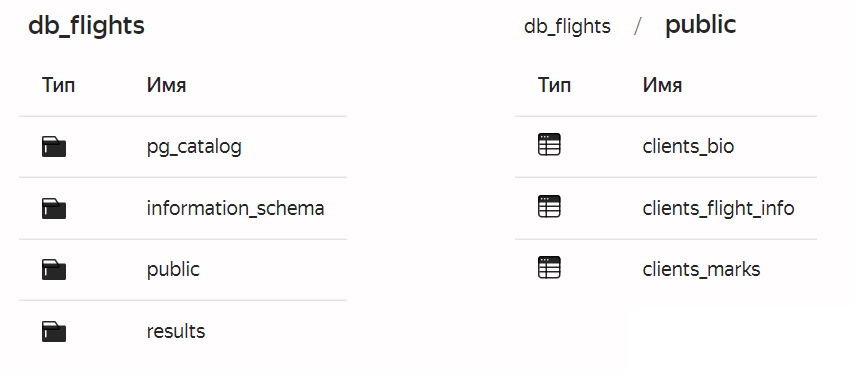

In [56]:
from contextlib import closing

with closing(psycopg2.connect(host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
                      port="6432",
                      dbname="db_flights",
                      user="mlhs_student",
                      password="mlhs_student",
                      target_session_attrs="read-write")) as conn:
    sql = '''
        select *
        from clients_bio t1 
        join clients_flight_info t2 on t1.id = t2.id
        join clients_marks t3 on t2.id = t3.id
    '''

    df = pd.read_sql_query(sql, conn)

In [57]:
df.head()

id  gender   age  id      Customer Type   Type of Travel     class  \
0   7    Male  43.0   7     Loyal Customer  Business travel  Business   
1  13    Male  24.0  13  disloyal Customer  Business travel       Eco   
2  18  Female  61.0  18     Loyal Customer  Personal Travel       Eco   
3  31    Male  35.0  31  disloyal Customer  Business travel  Business   
4  39  Female  46.0  39     Loyal Customer  Business travel  Business   

  Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  ...  \
0          1963.0                        0.0                      0.0  ...   
1           453.0                       16.0                     30.0  ...   
2           821.0                        0.0                      0.0  ...   
3           212.0                        0.0                      0.0  ...   
4            67.0                        0.0                      0.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
0              4.0          5.0                    5.0              5.0   
1              2.0          5.0                    5.0              2.0   
2              1.0          5.0                    5.0              5.0   
3              2.0          2.0                    2.0              4.0   
4              5.0          4.0                    4.0              4.0   

  Leg room service Baggage handling Checkin service Inflight service  \
0              5.0              5.0             4.0              5.0   
1              4.0              4.0             2.0              4.0   
2              2.0              5.0             5.0              5.0   
3              5.0              5.0             5.0              4.0   
4              4.0              4.0             5.0              4.0   

  cleanliness             satisfaction  
0         4.0                satisfied  
1         5.0  neutral or dissatisfied  
2         1.0  neutral or dissatisfied  
3         2.0  neutral or dissatisfied  
4         5.0                satisfied  

[5 rows x 26 columns]

Удалим повторяющиеся столбцы (колонка id)

In [58]:
df = df.loc[:,~df.columns.duplicated()]

Сохраним файл

In [59]:
df.to_csv("data_flights.csv",index=False)

Прочитаем из файла

In [60]:
df = pd.read_csv("data_flights.csv")

Установим в качестве индекса датафрейма колонку 'id'

In [61]:
df.set_index('id',inplace=True)
df = df.sort_index()

In [62]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
1     Male  48.0  disloyal Customer  Business travel  Business   
2   Female  35.0     Loyal Customer  Business travel  Business   
3     Male  41.0     Loyal Customer  Business travel  Business   
4     Male  50.0     Loyal Customer  Business travel  Business   
5   Female  49.0     Loyal Customer  Business travel  Business   

    Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
1             821.0                         2.0                       5.0   
2             821.0                        26.0                      39.0   
3             853.0                         0.0                       0.0   
4            1905.0                         0.0                       0.0   
5            3470.0                         0.0                       1.0   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                            ...   
1                     3.0                                3.0  ...   
2                     2.0                                2.0  ...   
3                     4.0                                4.0  ...   
4                     2.0                                2.0  ...   
5                     3.0                                3.0  ...   

    Online boarding  Seat comfort  Inflight entertainment  On-board service  \
id                                                                            
1               3.0           5.0                     5.0               3.0   
2               5.0           4.0                     5.0               5.0   
3               5.0           5.0                     3.0               3.0   
4               4.0           5.0                     5.0               5.0   
5               5.0           4.0                     3.0               3.0   

    Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                          
1                2.0               5.0              4.0               5.0   
2                5.0               5.0              3.0               5.0   
3                3.0               3.0              4.0               3.0   
4                5.0               5.0              3.0               5.0   
5                4.0               3.0              3.0               3.0   

    cleanliness             satisfaction  
id                                        
1           5.0  neutral or dissatisfied  
2           5.0                satisfied  
3           5.0                satisfied  
4           4.0                satisfied  
5           5.0                satisfied  

[5 rows x 23 columns]

In [63]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [64]:
df_columns = df.columns.tolist()

for col in df_columns:
  try:
    df[col] = df[col].astype(float)
  except:
    pass

In [13]:
df.dtypes

gender                                object
age                                  float64
Customer Type                         object
Type of Travel                        object
class                                 object
Flight Distance                      float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Inflight wifi service                float64
Departure/Arrival time convenient    float64
Ease of Online booking               float64
Gate location                        float64
Food and drink                       float64
Online boarding                      float64
Seat comfort                         float64
Inflight entertainment               float64
On-board service                     float64
Leg room service                     float64
Baggage handling                     float64
Checkin service                      float64
Inflight service                     float64
cleanliness                          float64
satisfacti

In [65]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

В данных есть выбросы. Например, по возрасту есть люди, которым сильно больше чем 100 лет

In [66]:
df[df['age'] > 100]

gender    age      Customer Type   Type of Travel     class  \
id                                                                    
29        Male  320.0     Loyal Customer  Business travel  Business   
75      Female  184.0  disloyal Customer  Business travel       Eco   
596     Female  176.0     Loyal Customer  Business travel  Business   
770       Male  300.0                NaN  Business travel  Business   
1314      Male  272.0     Loyal Customer  Business travel  Business   
...        ...    ...                ...              ...       ...   
128950  Female  144.0     Loyal Customer  Business travel  Business   
129458    Male  448.0     Loyal Customer  Business travel  Business   
129519  Female  234.0  disloyal Customer  Business travel  Business   
129639    Male  144.0     Loyal Customer  Business travel  Business   
129857    Male  168.0  disloyal Customer  Business travel  Business   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
29               3734.0                         0.0                      52.0   
75                108.0                         0.0                       0.0   
596                89.0                        25.0                      23.0   
770              2883.0                         0.0                       0.0   
1314              247.0                         0.0                       0.0   
...                 ...                         ...                       ...   
128950           3984.0                         0.0                       0.0   
129458           2764.0                         0.0                       0.0   
129519           2583.0                         0.0                       1.0   
129639            337.0                         0.0                       0.0   
129857            337.0                        46.0                      43.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
29                        4.0                                4.0  ...   
75                        2.0                                5.0  ...   
596                       1.0                                1.0  ...   
770                       1.0                                3.0  ...   
1314                      0.0                                0.0  ...   
...                       ...                                ...  ...   
128950                    1.0                                1.0  ...   
129458                    3.0                                3.0  ...   
129519                    1.0                                3.0  ...   
129639                    1.0                                1.0  ...   
129857                    4.0                                4.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
29                  4.0           4.0                     5.0   
75                  1.0           2.0                     2.0   
596                 4.0           5.0                     4.0   
770                 2.0           3.0                     2.0   
1314                5.0           5.0                     3.0   
...                 ...           ...                     ...   
128950              4.0           4.0                     4.0   
129458              4.0           5.0                     4.0   
129519              1.0           2.0                     3.0   
129639              5.0           4.0                     5.0   
129857              4.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
29                   5.0               5.0               5.0            

In [67]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

В данных есть пропуски

In [68]:
df.describe(include = ['object'])

gender   Customer Type   Type of Travel     class  \
count   129549          129472           129448    129433   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

In [69]:
df['Customer Type'].unique()

array(['disloyal Customer', 'Loyal Customer', nan], dtype=object)

In [70]:
df['Type of Travel'].unique()

array(['Business travel', 'Personal Travel', nan], dtype=object)

In [71]:
df['class'].unique()

array(['Business', 'Eco', 'Eco Plus', nan], dtype=object)

In [72]:
df['satisfaction'].unique()

array(['neutral or dissatisfied', 'satisfied', '-'], dtype=object)

В категориальных признаках тоже есть пропуски.

'-' в satisfaction будем предсказывать.

(0.25 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

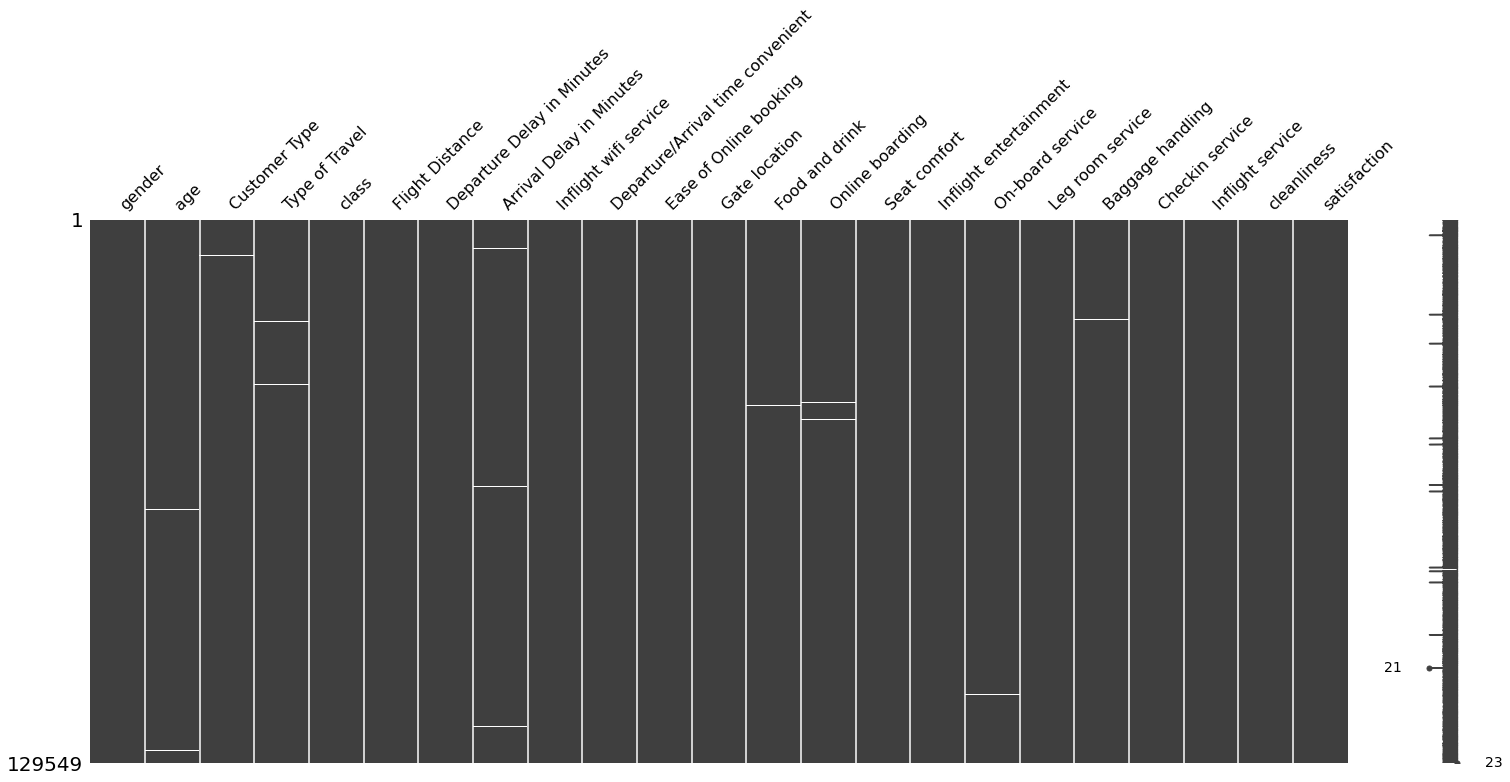

In [73]:
missingno.matrix(df);

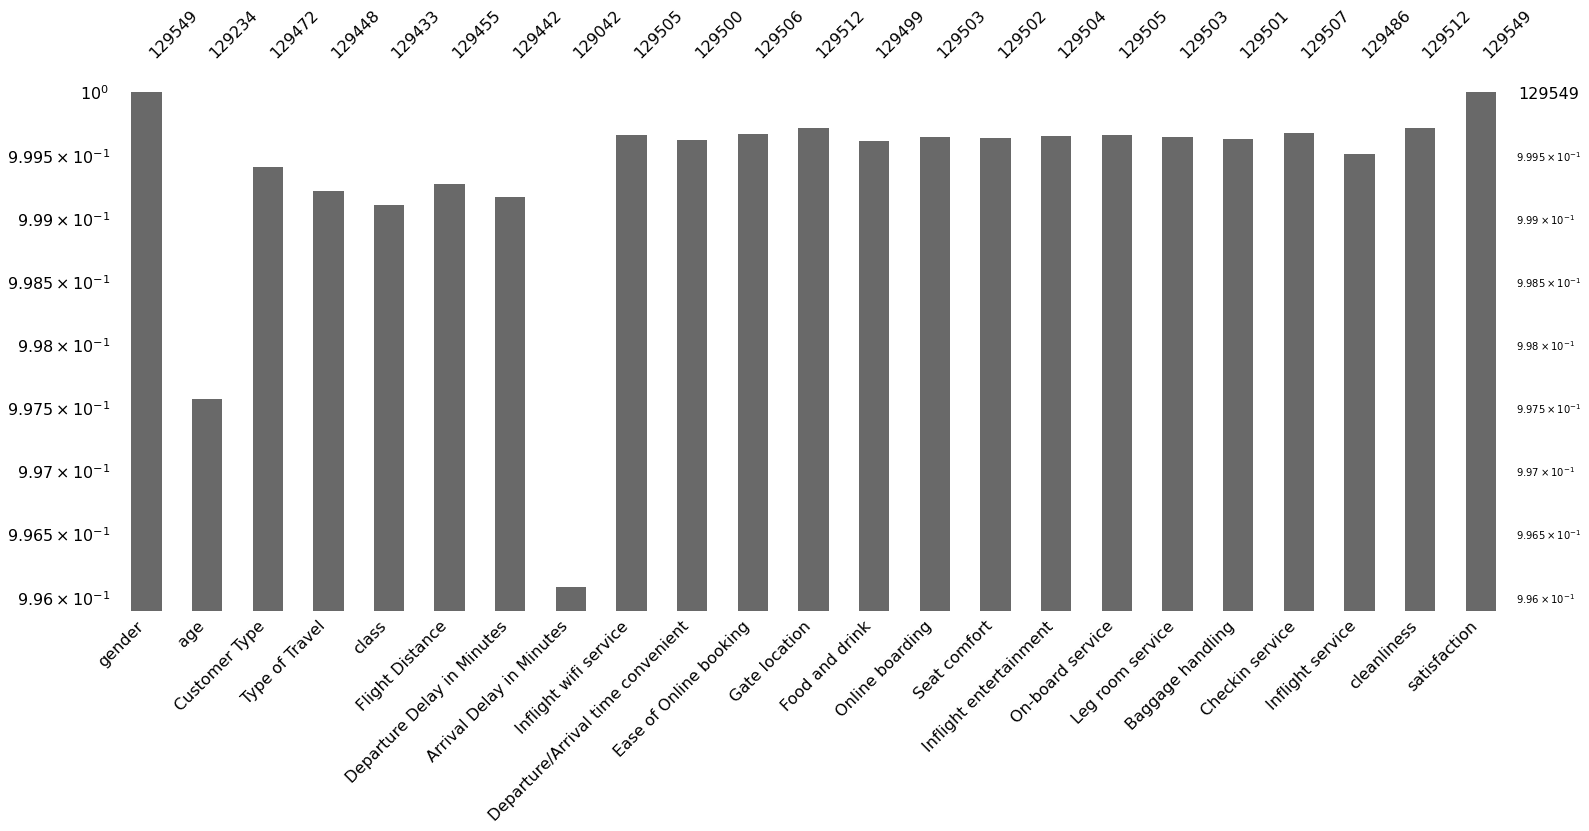

In [74]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [117]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
1         Male  48.0  disloyal Customer  Business travel  Business   
2       Female  35.0     Loyal Customer  Business travel  Business   
3         Male  41.0     Loyal Customer  Business travel  Business   
4         Male  50.0     Loyal Customer  Business travel  Business   
5       Female  49.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129874  Female  28.0     Loyal Customer  Personal Travel  Eco Plus   
129875  Female  55.0     Loyal Customer  Personal Travel  Eco Plus   
129878    Male  42.0     Loyal Customer  Personal Travel  Eco Plus   
129879    Male  50.0     Loyal Customer  Personal Travel  Eco Plus   
129880  Female  20.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
1                 821.0                         2.0                       5.0   
2                 821.0                        26.0                      39.0   
3                 853.0                         0.0                       0.0   
4                1905.0                         0.0                       0.0   
5                3470.0                         0.0                       1.0   
...                 ...                         ...                       ...   
129874            337.0                         0.0                       0.0   
129875            308.0                         0.0                       0.0   
129878            337.0                         6.0                      14.0   
129879            337.0                        31.0                      22.0   
129880            337.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
1                         3.0                                3.0  ...   
2                         2.0                                2.0  ...   
3                         4.0                                4.0  ...   
4                         2.0                                2.0  ...   
5                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129874                    4.0                                2.0  ...   
129875                    3.0                                4.0  ...   
129878                    2.0                                5.0  ...   
129879                    5.0                                4.0  ...   
129880                    3.0                                1.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
1                   3.0           5.0                     5.0   
2                   5.0           4.0                     5.0   
3                   5.0           5.0                     3.0   
4                   4.0           5.0                     5.0   
5                   5.0           4.0                     3.0   
...                 ...           ...                     ...   
129874              4.0           3.0                     3.0   
129875              4.0           3.0                     4.0   
129878              2.0           3.0                     3.0   
129879              4.0           4.0                     3.0   
129880              3.0           2.0                     2.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
1                    3.0               2.0               5.0              4.0   
2   

In [118]:
assert df_train.shape == (103_644, 23)

In [119]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
17      Female  48.0     Loyal Customer  Personal Travel       Eco   
20      Female  42.0     Loyal Customer  Personal Travel       Eco   
35        Male  39.0     Loyal Customer  Business travel  Business   
44        Male  51.0     Loyal Customer  Business travel  Business   
49        Male  20.0  disloyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
129847  Female  16.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129872  Female  32.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   
129877    Male  41.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
17                821.0                         0.0                       0.0   
20                821.0                         4.0                       0.0   
35               1672.0                        23.0                      17.0   
44               2077.0                         0.0                       1.0   
49                108.0                         0.0                      29.0   
...                 ...                         ...                       ...   
129847            337.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129872            337.0                         0.0                       1.0   
129876            447.0                         2.0                       3.0   
129877            308.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
17                        2.0                                3.0  ...   
20                        3.0                                3.0  ...   
35                        2.0                                2.0  ...   
44                        4.0                                1.0  ...   
49                        4.0                                5.0  ...   
...                       ...                                ...  ...   
129847                    0.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129872                    4.0                                2.0  ...   
129876                    4.0                                4.0  ...   
129877                    3.0                                5.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
17                 1.0              5.0           1.0                     5.0   
20                 1.0              3.0           4.0                     1.0   
35                 5.0              4.0           5.0                     3.0   
44                 2.0              5.0           5.0                     5.0   
49                 5.0              4.0           3.0                     5.0   
...                ...              ...           ...                     ...   
129847             3.0              0.0           3.0                     3.0   
129868             4.0              3.0           4.0                     4.0   
129872             4.0              4.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   
129877             2.0              3.0           2.0                     2.0   

        On-board service  Leg room serv

In [120]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [121]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [122]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [123]:
train_mode = X_train.mode()

In [124]:
train_mode

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
0  Female  39.0  Loyal Customer  Business travel  Business            337.0   

   Departure Delay in Minutes  Arrival Delay in Minutes  \
0                         0.0                       0.0   

   Inflight wifi service  Departure/Arrival time convenient  ...  \
0                    3.0                                4.0  ...   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
0             4.0              4.0           4.0                     4.0   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0               4.0               4.0               4.0              4.0   

   Inflight service  cleanliness  
0               4.0          4.0  

[1 rows x 22 columns]

In [125]:
columns = X_train.columns
for col in columns:
    X_train[col] = X_train[col].replace(np.nan, train_mode[col][0])
    X_val[col] = X_val[col].replace(np.nan, train_mode[col][0])
    df_test[col] = df_test[col].replace(np.nan, train_mode[col][0])

Проверим, что пропуском теперь нет

In [84]:
X_train.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [85]:
X_train['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [86]:
X_train['Type of Travel'].unique()

array(['Business travel', 'Personal Travel'], dtype=object)

In [87]:
X_train['Customer Type'].unique()

array(['Loyal Customer', 'disloyal Customer'], dtype=object)

In [88]:
X_train['class'].unique()

array(['Business', 'Eco', 'Eco Plus'], dtype=object)

Все пропуски заполнились, аналогично df_test и X_val должны заполнится

In [89]:
X_val.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [90]:
df_test.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [91]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.083666      1338.222261                   15.642591   
std       20.355546      4838.640464                   67.829985   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       842.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      612.000000    328510.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.381116               2.735603   
std                  100.546087               1.366913   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.063556                2.760744   
std                             1.556199                1.416293   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               36.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.981792        3.208132         3.259821      3.444328   
std         1.302569        1.357203         1.393320      1.344373   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       45.000000        40.000000     36.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362660          3.382977          3.355093   
std                  1.368691          1.334893          1.371754   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.633770         3.311647          3.644383      3.289690  
std            1.234864         1.311884          1.215434      1.345367  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [92]:
X_train.describe(include = ['object'])

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36738           59364            50046     34639

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

В числовых признаках выбросы есть почти во всех столбцах. Так например, ярко выраженные выбросы наблюдаются в колонке с возрастом, где есть значения 0 и 628 лет. Для Flight Distance максимальное значение 328510 также является выбросом. В колонках с оценкой от 1 до 5 есть значения 36, 40, 45.

В категориальных признаках Customer Type и Type of Travel распределенны неравномерно.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах.</font> Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [126]:
quantile_996 = X_train.quantile(.996)
columns = X_train.columns
object_columns = X_train.select_dtypes(include='object').columns
for col in columns:
  if col not in object_columns:
    X_train = X_train[X_train[col] <= quantile_996[col]]
    X_val = X_val[X_val[col] <= quantile_996[col]]

In [127]:
assert X_train.shape == (71_369, 22)
assert X_val.shape == (30_591, 22)
assert df_test.shape == (25_905, 22)

In [128]:
y_train = y_train[X_train.index]
y_val = y_val[X_val.index]

## EDA (1 балл + 0.25)

Создадим переменные с перечислениями столбцов разного типа

In [129]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [97]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [47]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        fg = plt.figure(figsize=(15, 8))
        title = f"{col} distribution"
        ax = sns.countplot(data=df, x=col, hue=y).set(title=title)

In [48]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    for col in cols:
      fg = plt.figure(figsize=(15,8))
      plt.subplot(1,2,1)
      title_distribution = f"{col} distribution"
      sns.kdeplot(data=df, x=col, hue=y).set(title=title_distribution)

      plt.subplot(1,2,2)
      title_boxplot = f"{col} boxplot by target"
      sns.boxplot(data=df, x=col, y=y).set(title=title_boxplot)

In [49]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        fg = plt.figure(figsize=(15, 8))
        title = f"{col} distribution"
        ax = sns.countplot(data=df, x=col, hue=y)

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

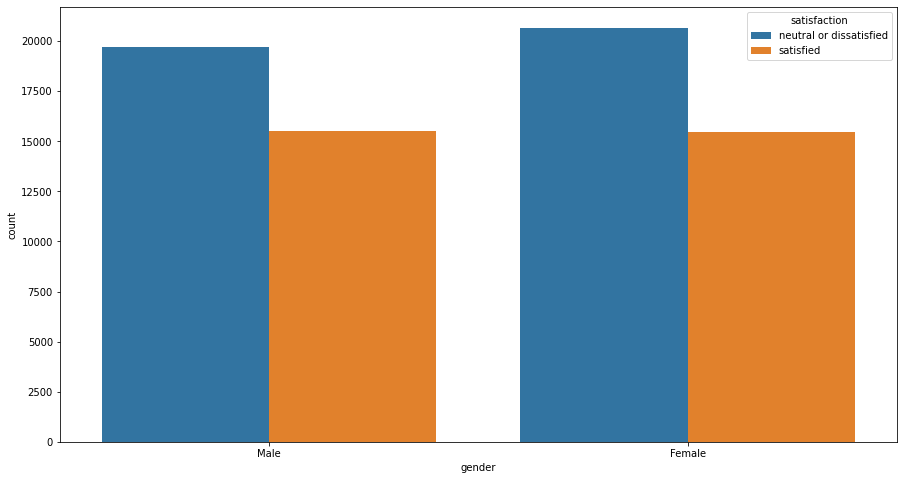

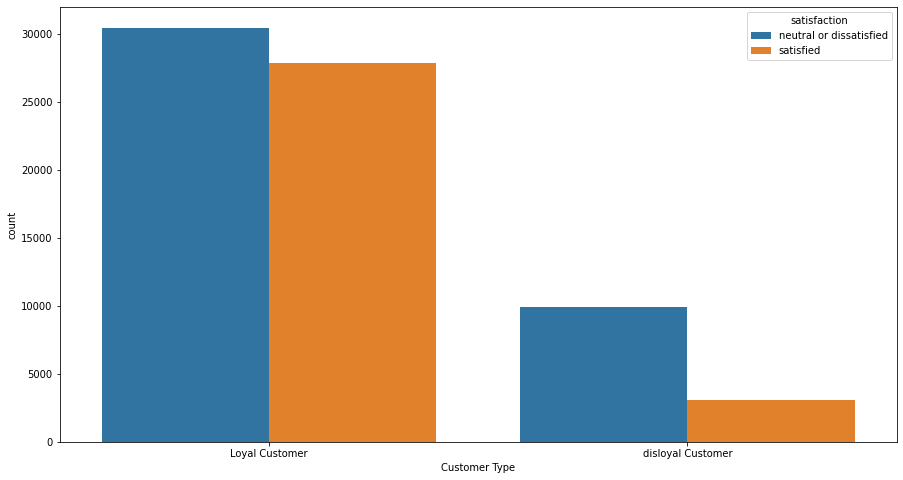

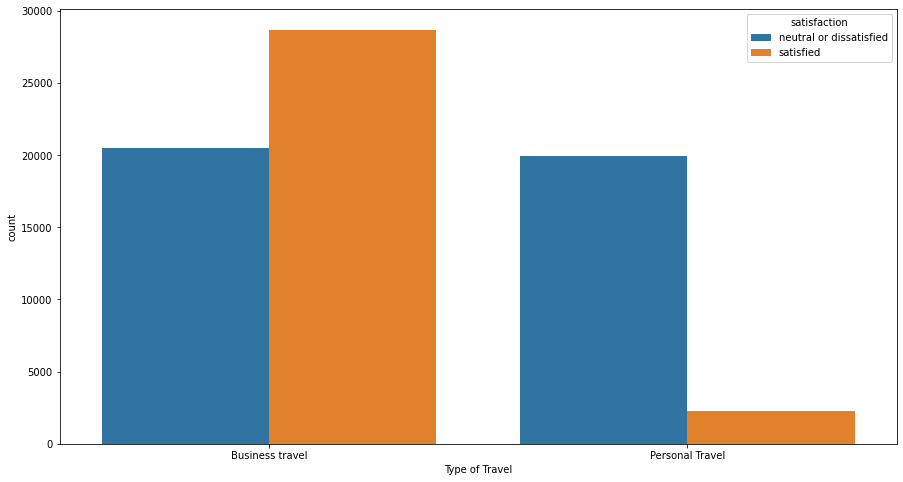

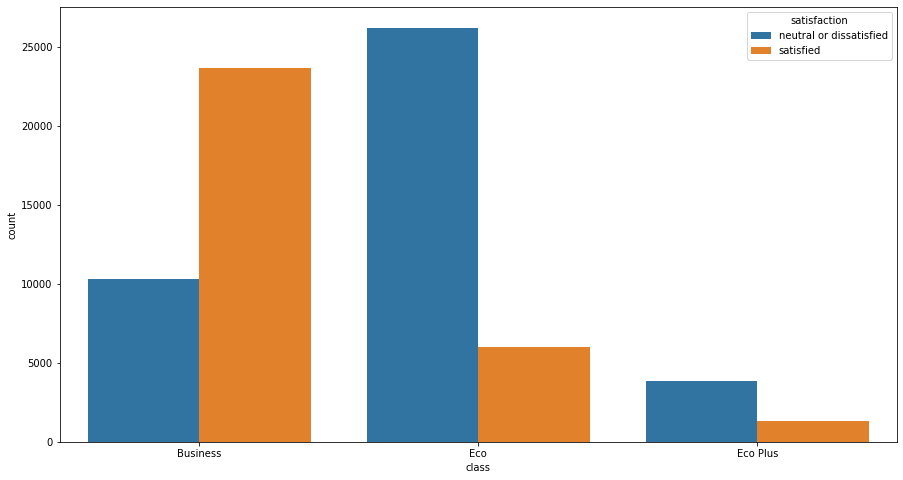

In [98]:
plot_categorical(categorical_cols, X_train, y_train)

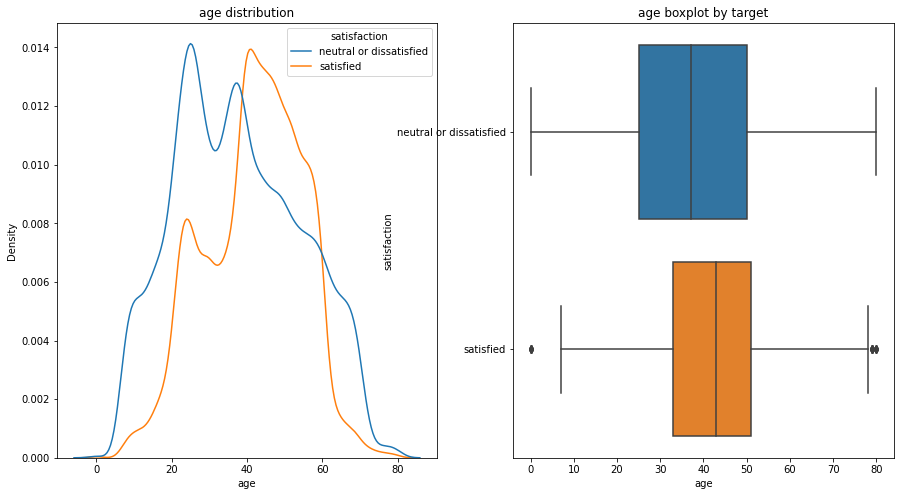

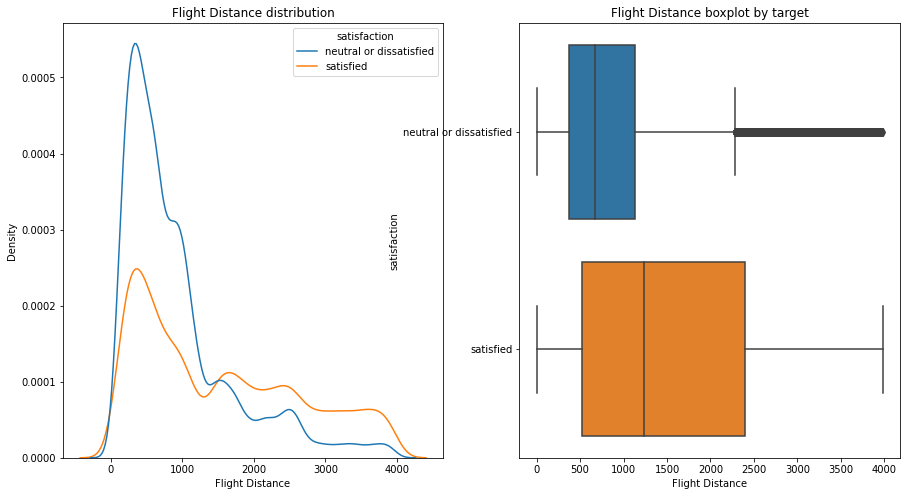

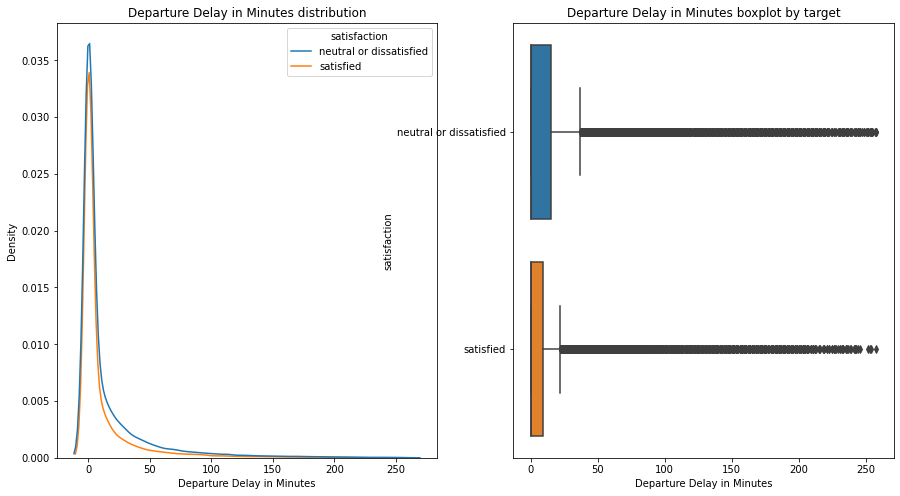

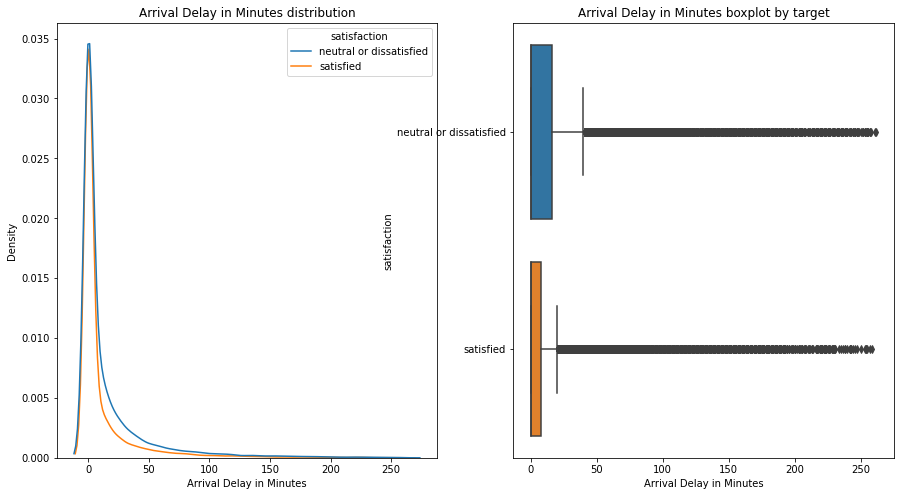

In [99]:
plot_continuous(continuous_cols, X_train, y_train)

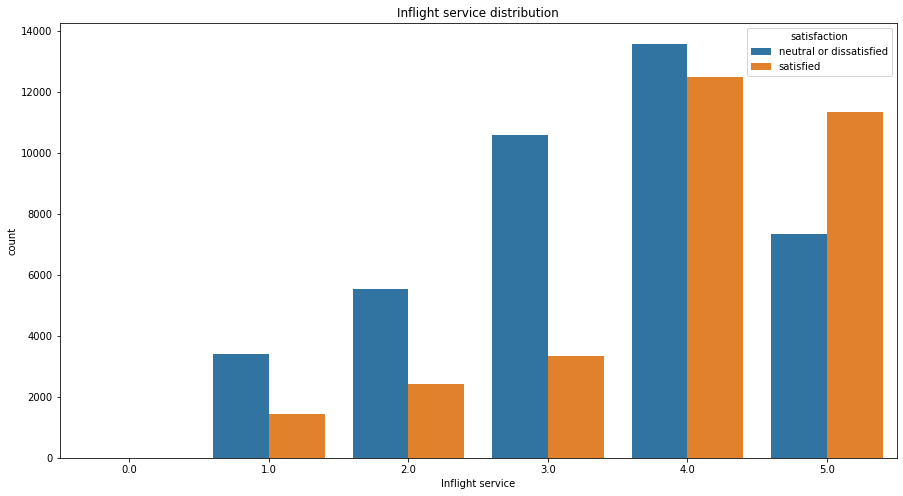

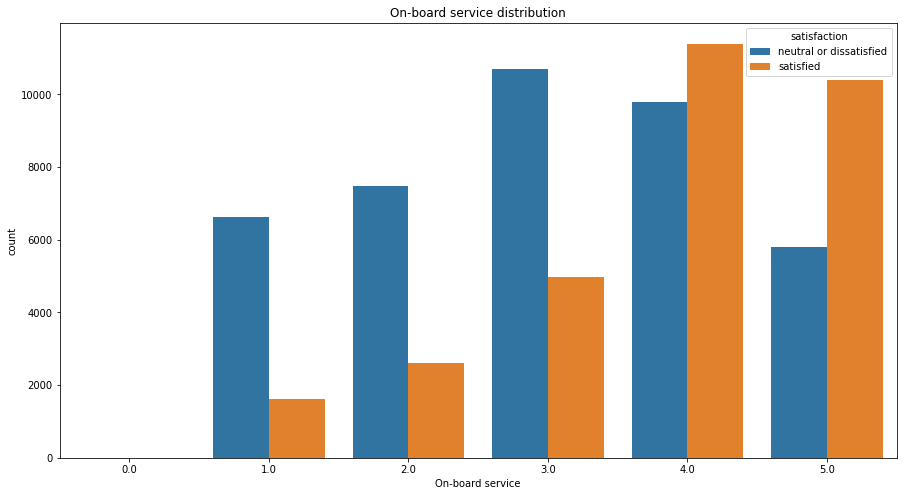

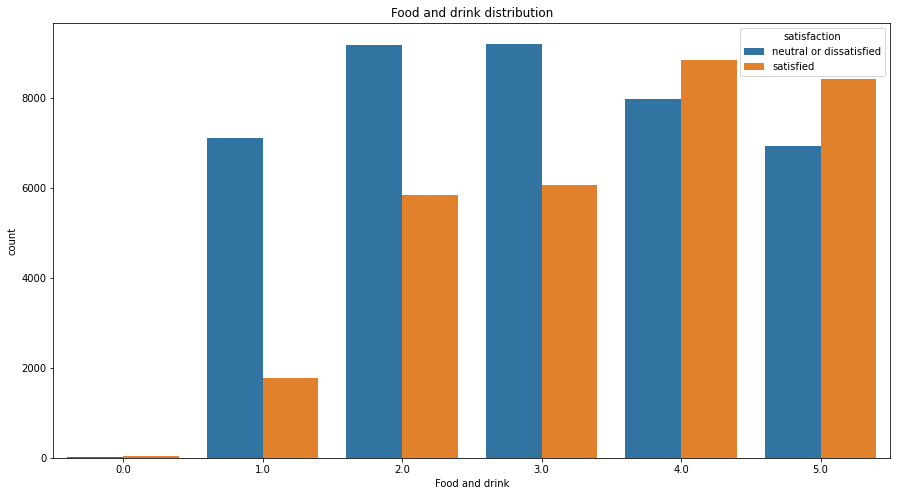

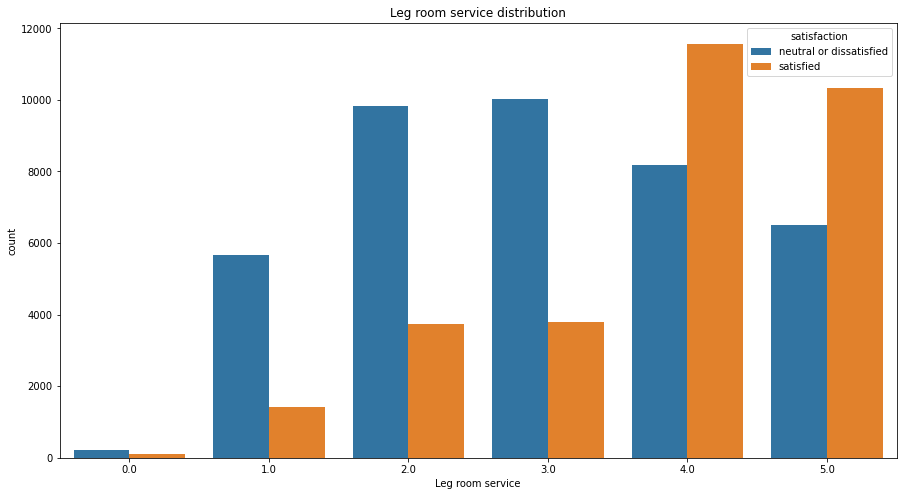

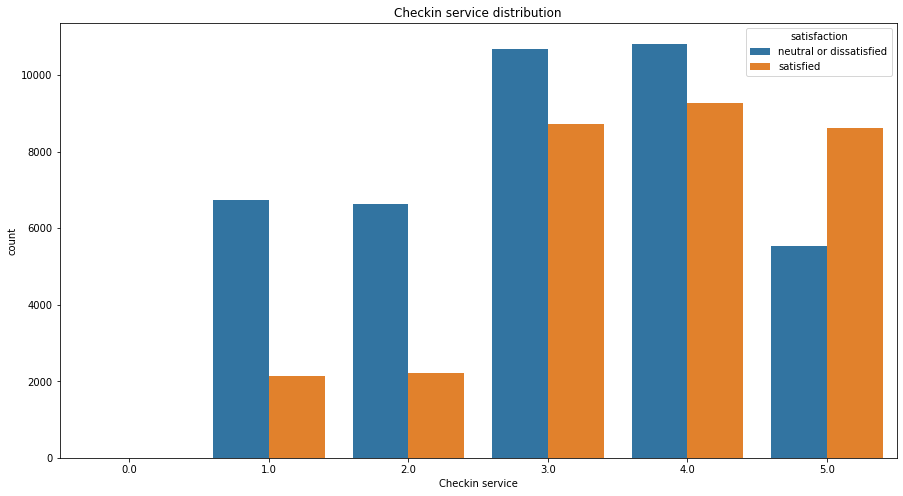

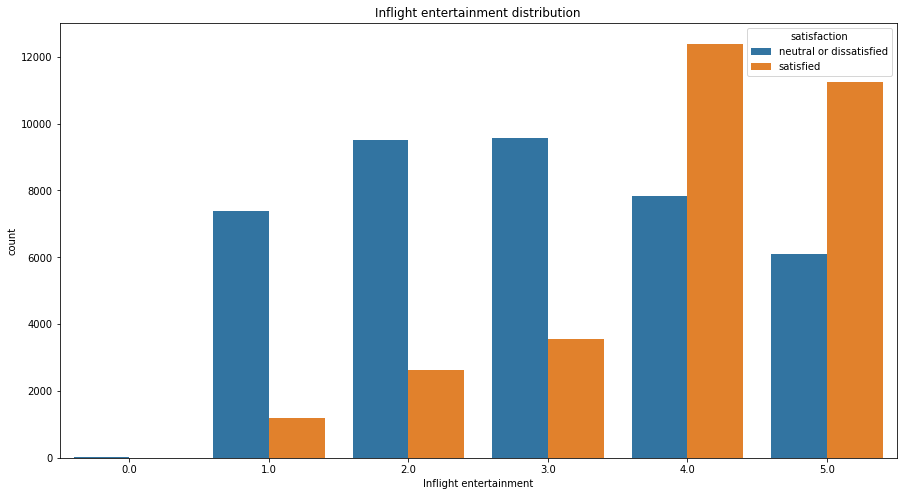

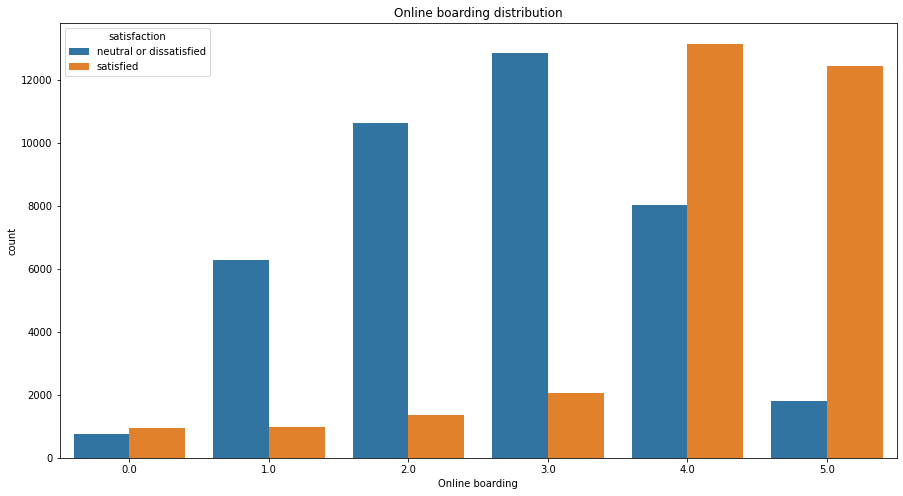

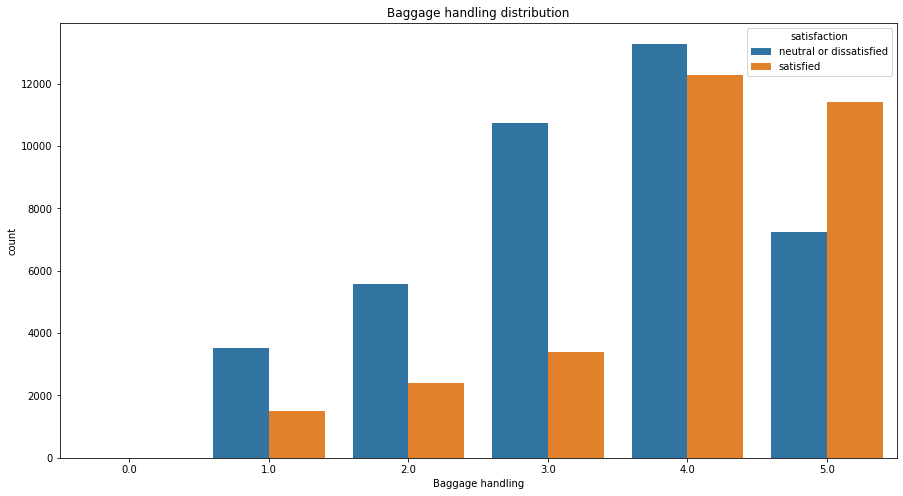

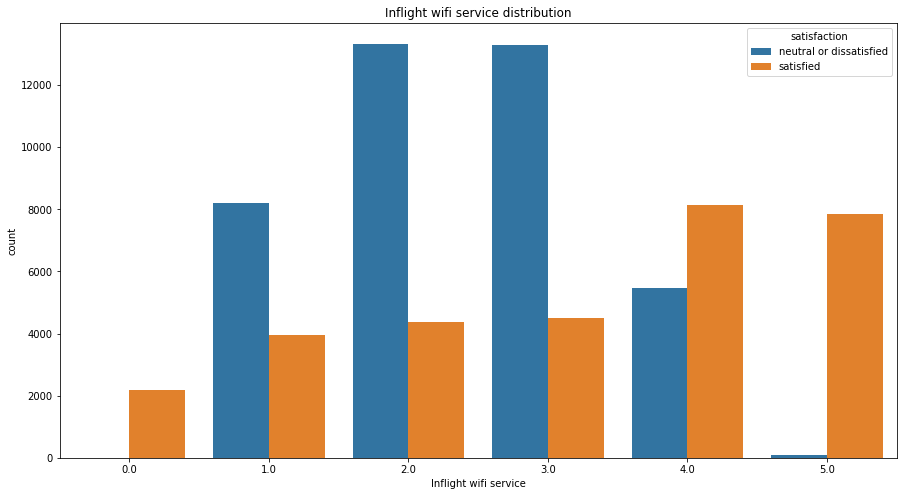

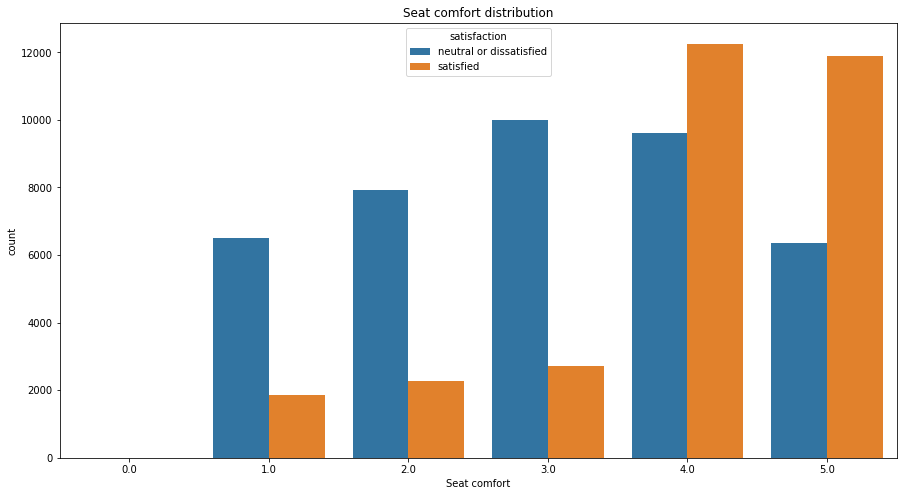

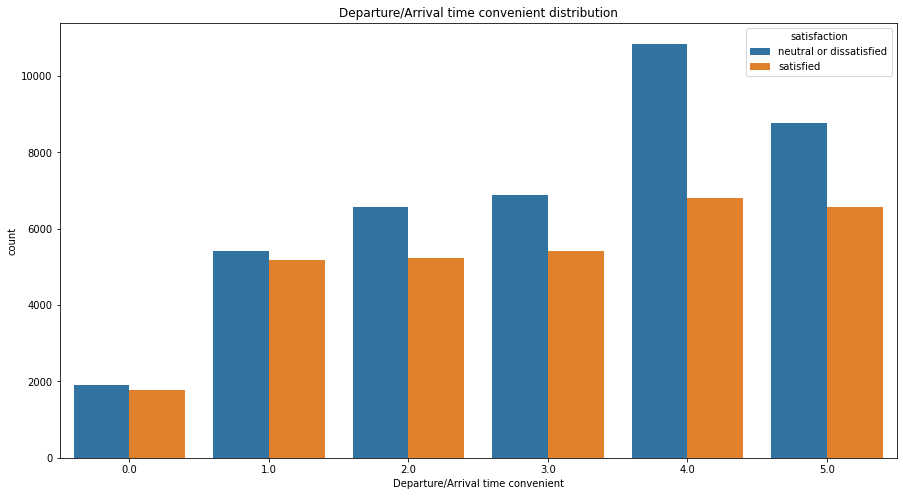

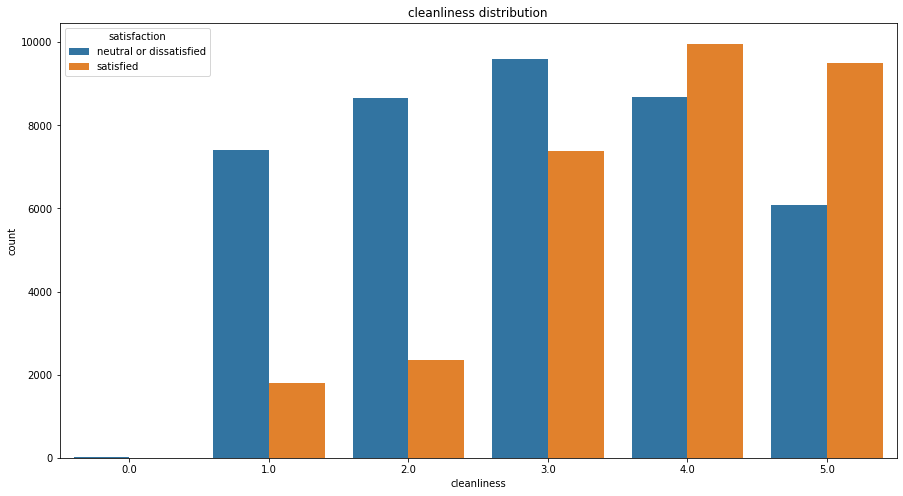

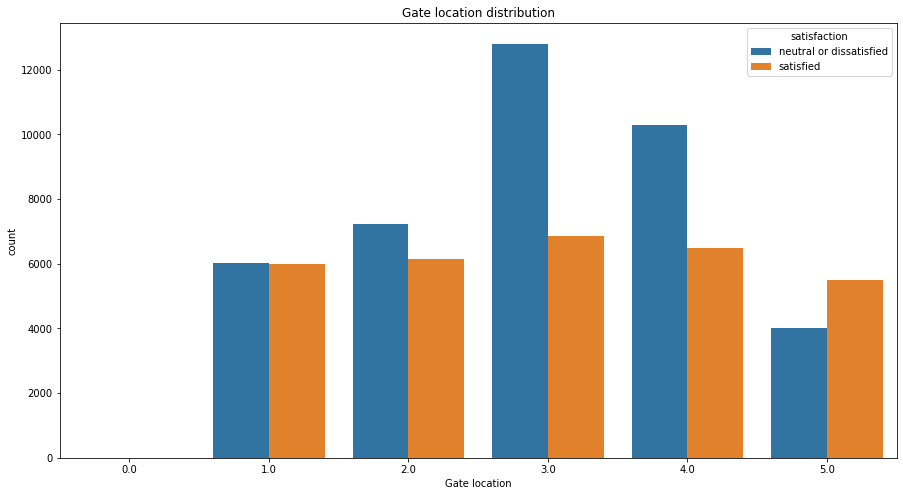

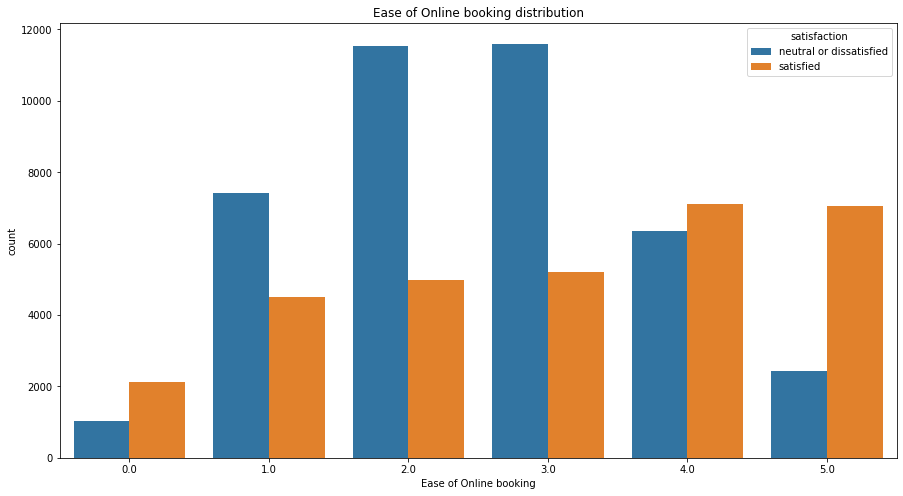

In [100]:
plot_ordinal(ordinal_cols, X_train, y_train)

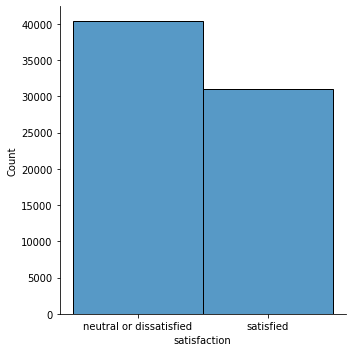

In [101]:
# visualize y_train
sns.displot(y_train);

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

Категориальные признаки:
- По полу данные сбалансированы, целевое значение для них примерно одинаковое.
- По типу клиента данные распределены неравномерно, лояльных клиентов больше, при этом количество положительных и нейтрально-отрицательных оценок почти совпадает. У нелояльных больше всего нейтрально-отрицательных оценок.
- По типу поездки данные распределены неравномерно, бизнес поездок больше чем персональных. Также больше всего положительных оценок наблюдается именно у бизнес поездок, личные поездки оценивают в основном как нейтрально-отрицательные.
- По классу поездок количество бизнес поездок и эко почти совпадает, эко+ пользуются меньше всего. Больше всего положительных отзывов от бизнес поездок. Эко и эко+ в основном оцениваются как нейтрально-отрицательные.

Порядковые признаки:
- В основном классы несбаласированы.
- Равномерное распределение классов заметна в столбцах 'food and drink', 'Departure/Arrival time convenient', 'Gate location', 'Ease of Online booking'.

Континуальные признаков:
- по возрасту данные имеют нормальное распределение, по всем остальны признакам наблюдается логарифмически нормальное распределение.

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

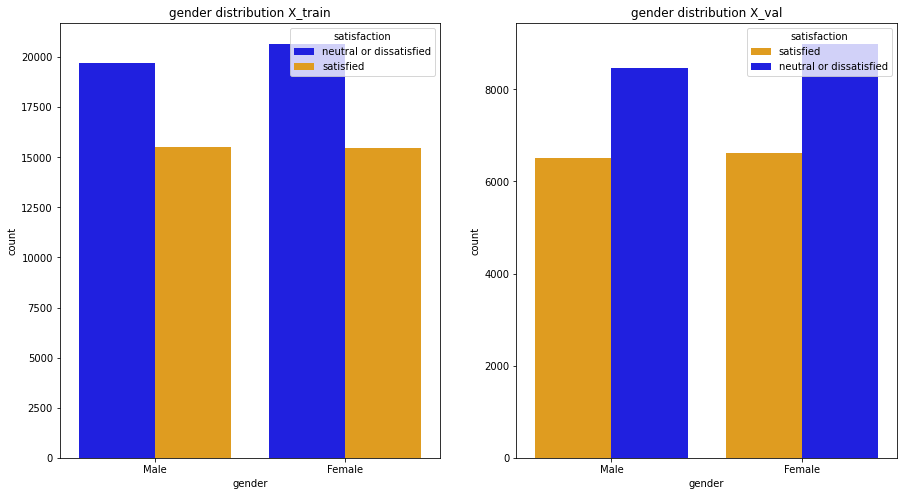

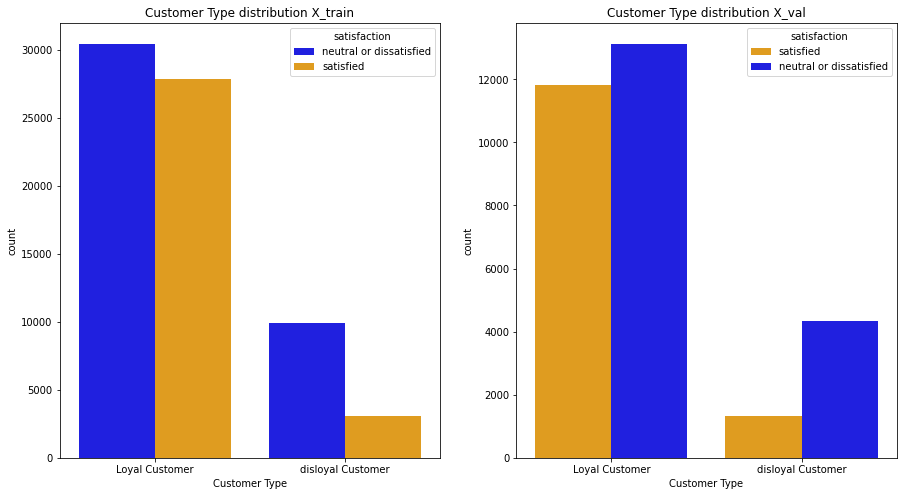

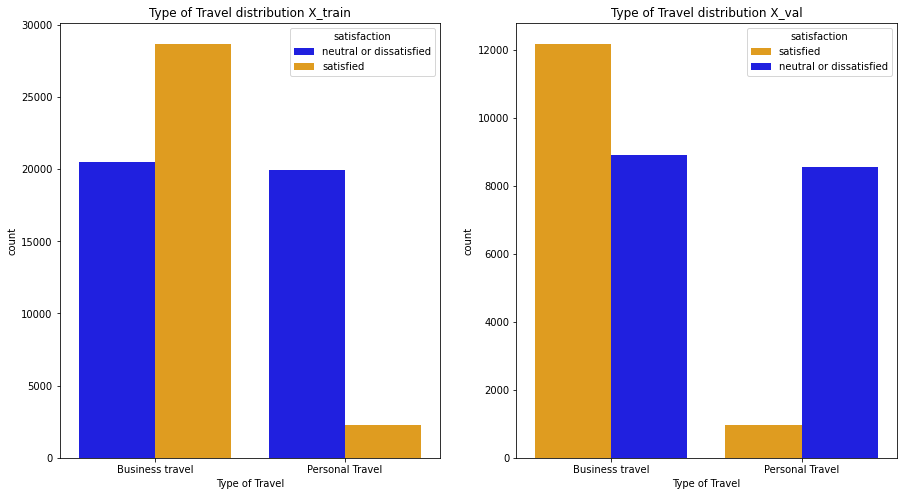

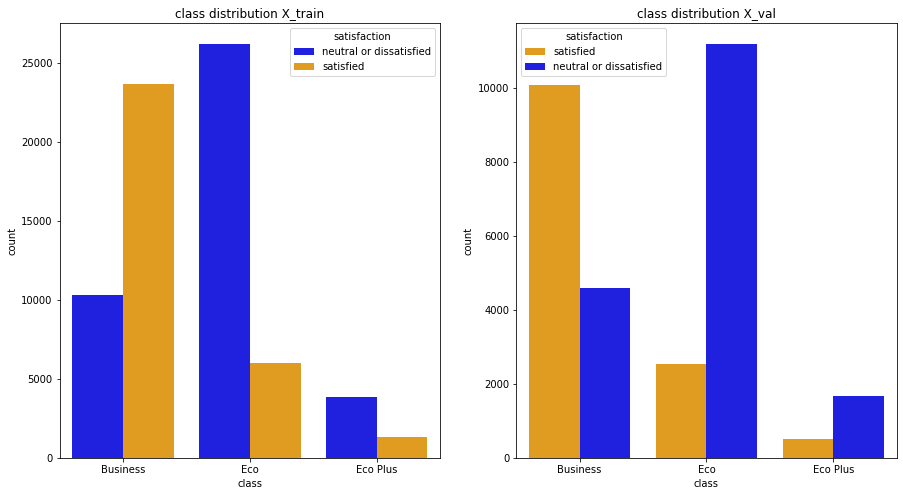

In [109]:
for col in categorical_cols:
   plt.figure(figsize=(15,8))

   plt.subplot(1,2,1)
   title_train = f"{col} distribution X_train"
   sns.countplot(data=X_train, x=col, hue=y_train, palette=["blue","orange"]).set(title=title_train)

   plt.subplot(1,2,2)
   title_val = f"{col} distribution X_val"
   sns.countplot(data=X_val, x=col, hue=y_val, palette=["orange","blue"]).set(title=title_val) 



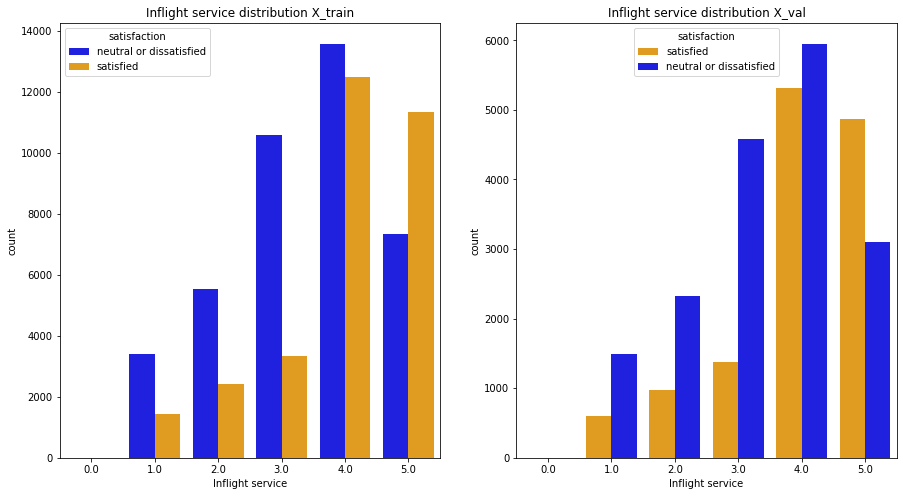

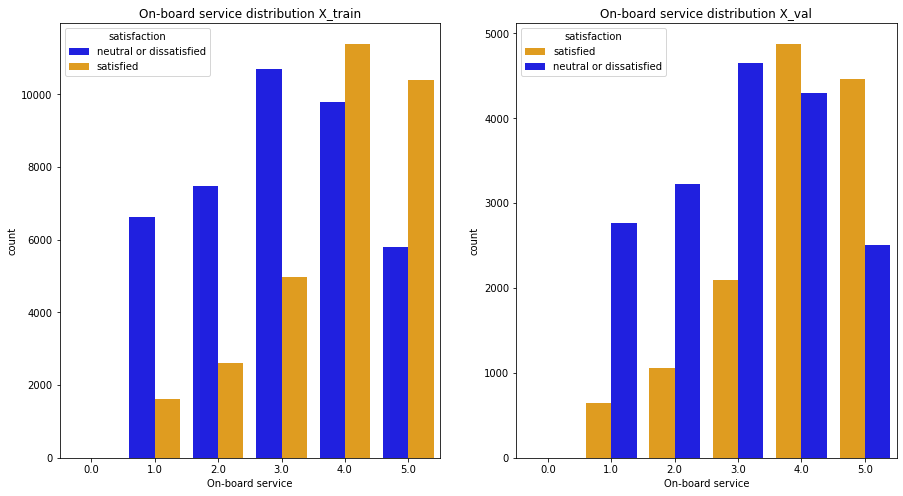

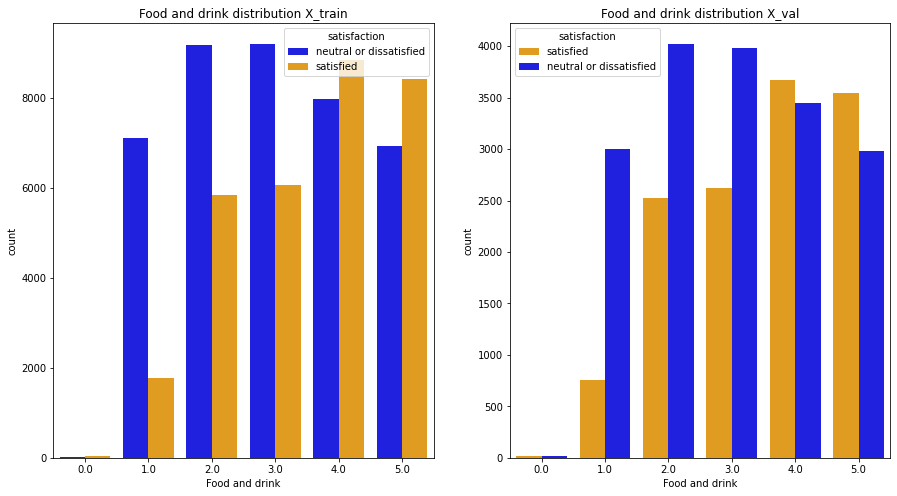

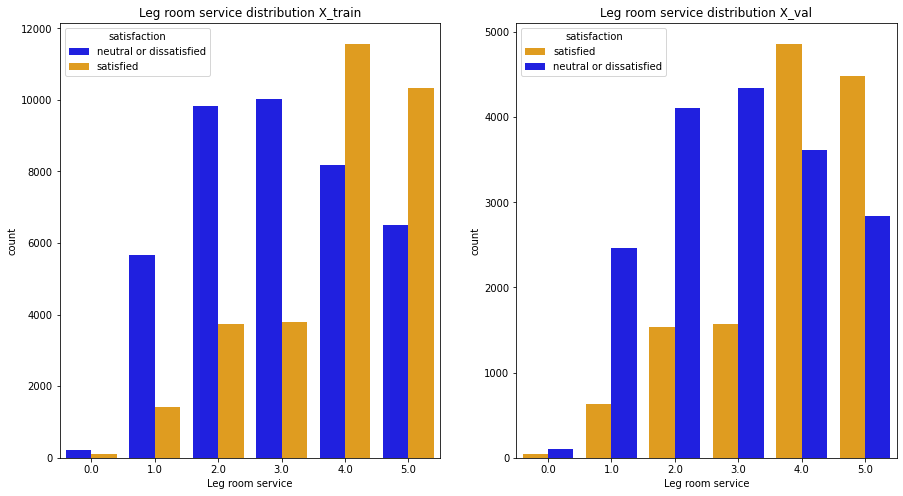

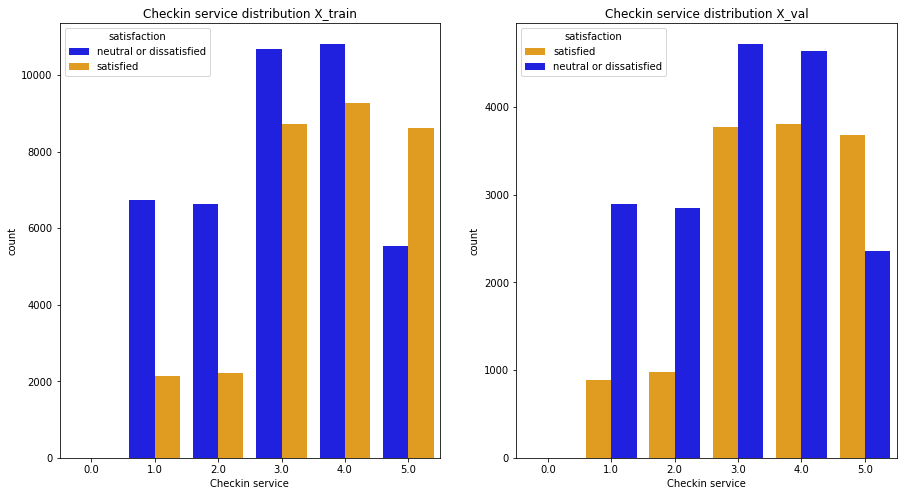

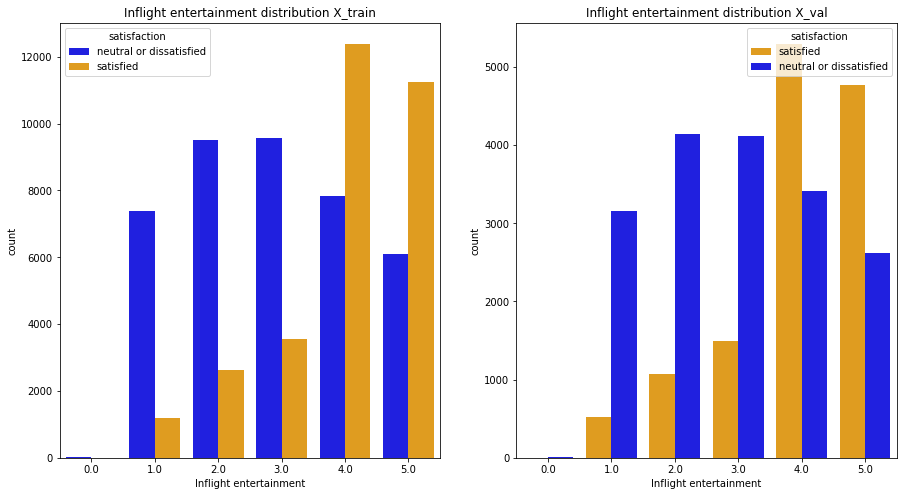

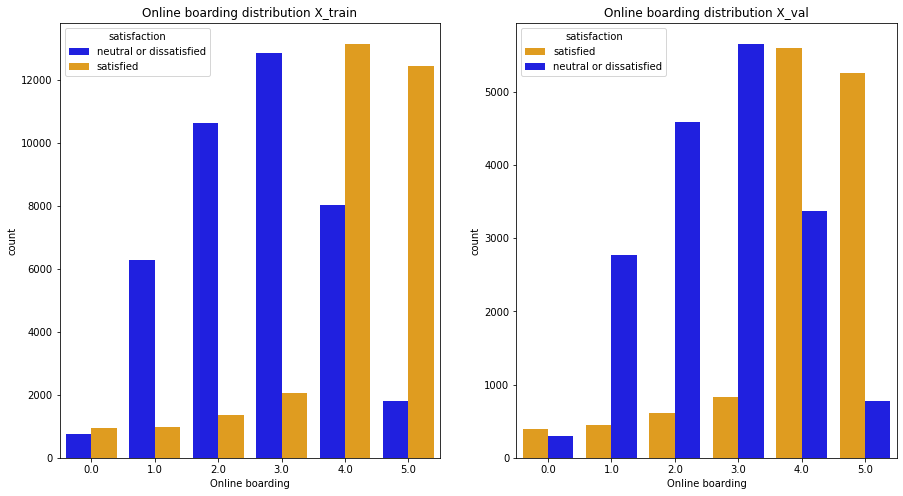

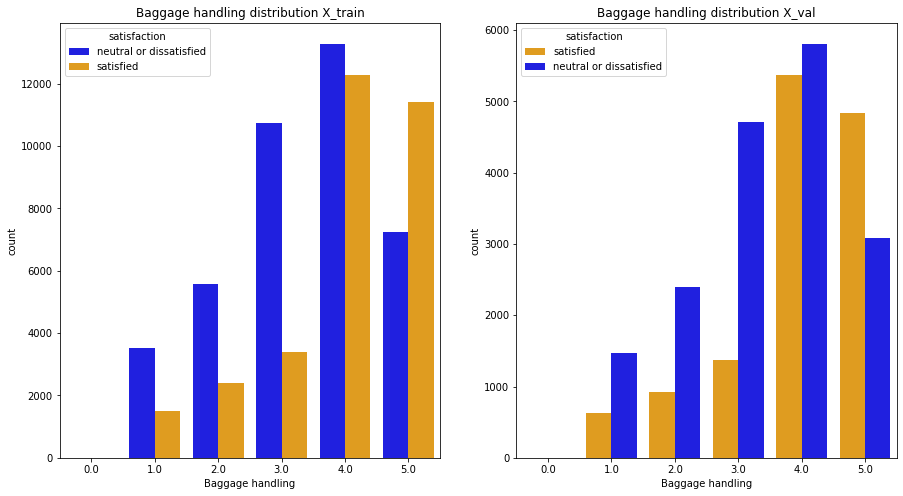

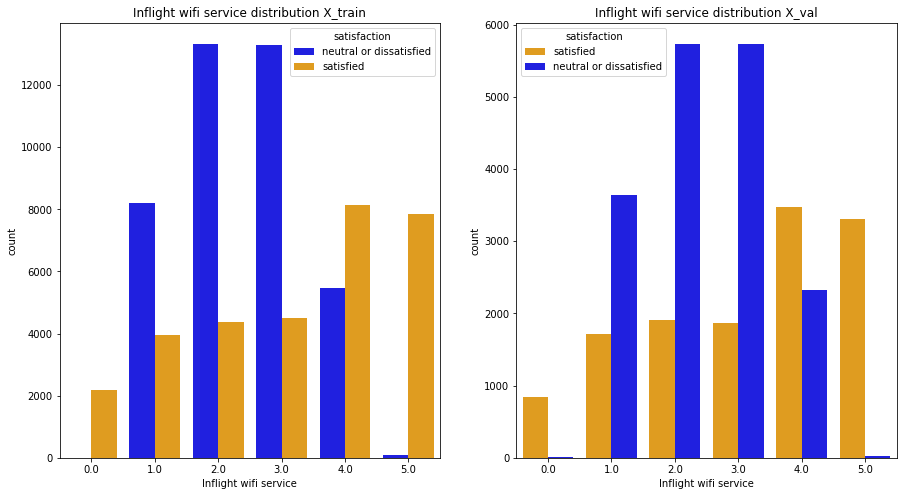

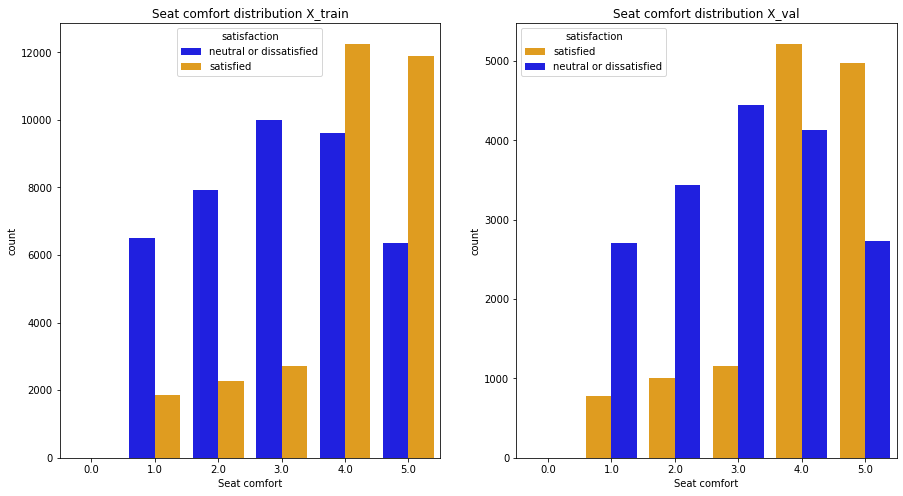

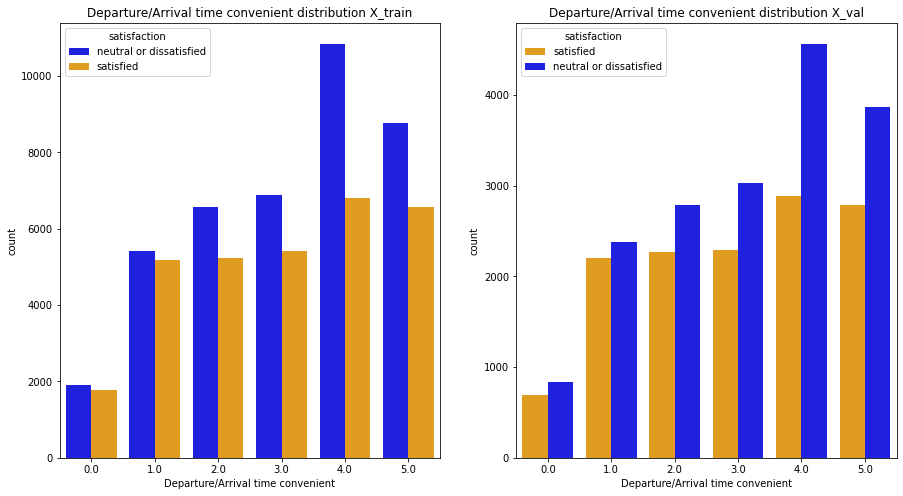

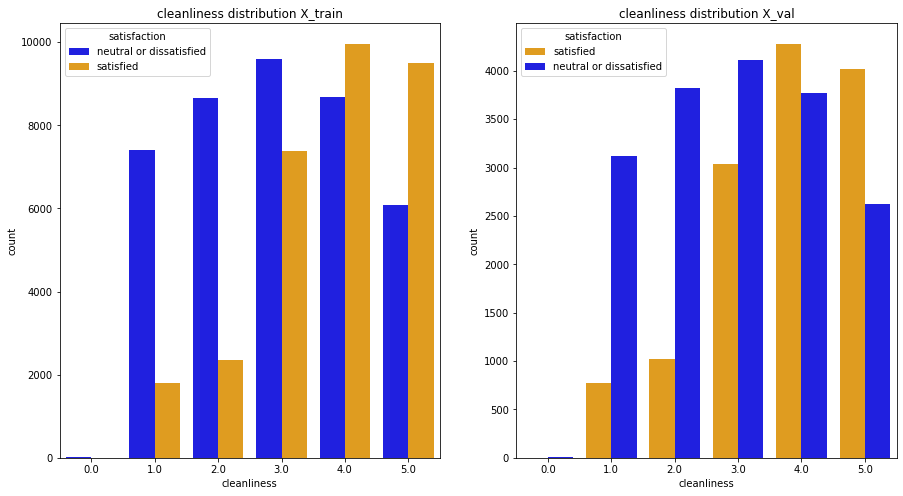

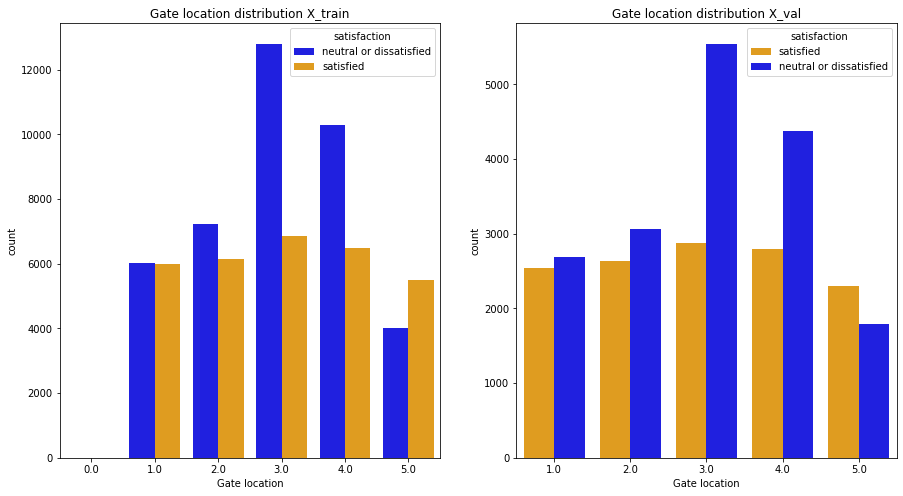

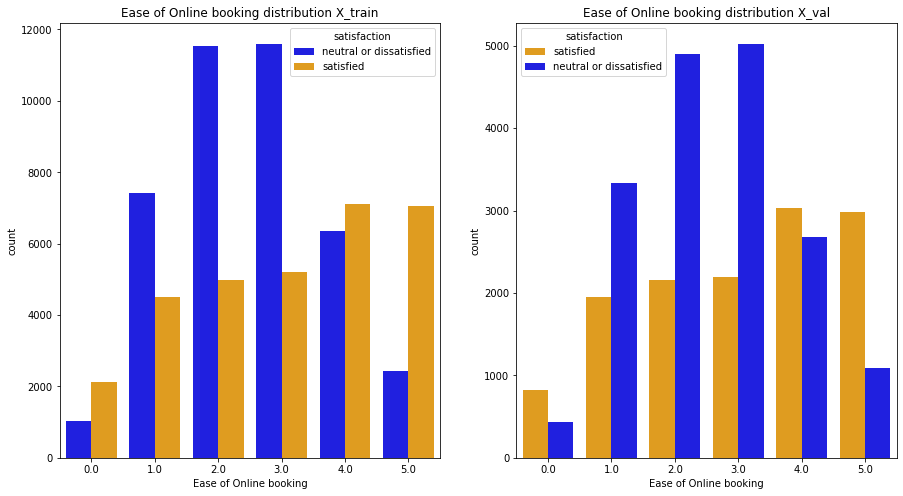

In [108]:
for col in ordinal_cols:
   plt.figure(figsize=(15,8))

   plt.subplot(1,2,1)
   title_train = f"{col} distribution X_train"
   sns.countplot(data=X_train, x=col, hue=y_train, palette=["blue","orange"]).set(title=title_train)

   plt.subplot(1,2,2)
   title_val = f"{col} distribution X_val"
   sns.countplot(data=X_val, x=col, hue=y_val, palette=["orange","blue"]).set(title=title_val) 

Визуально сравнивая построенные графики для категориальных и порядковых признаках, можно сделать вывод о том, что данные распределились равномерно по train и val. 

PS: внимательно смотрите на легенду.

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [130]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

In [131]:
X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])

In [132]:
df_test['Departure Delay in Minutes'] = np.log1p(df_test['Departure Delay in Minutes'])
df_test['Arrival Delay in Minutes'] = np.log1p(df_test['Arrival Delay in Minutes'])

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

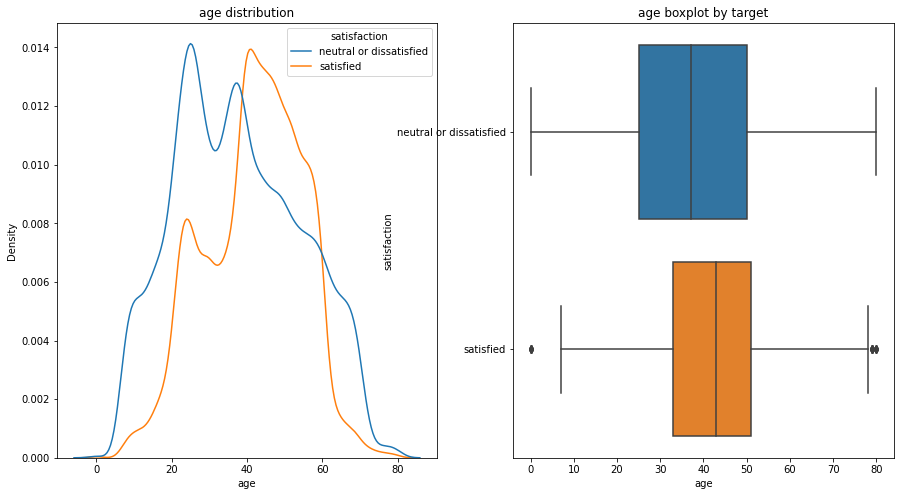

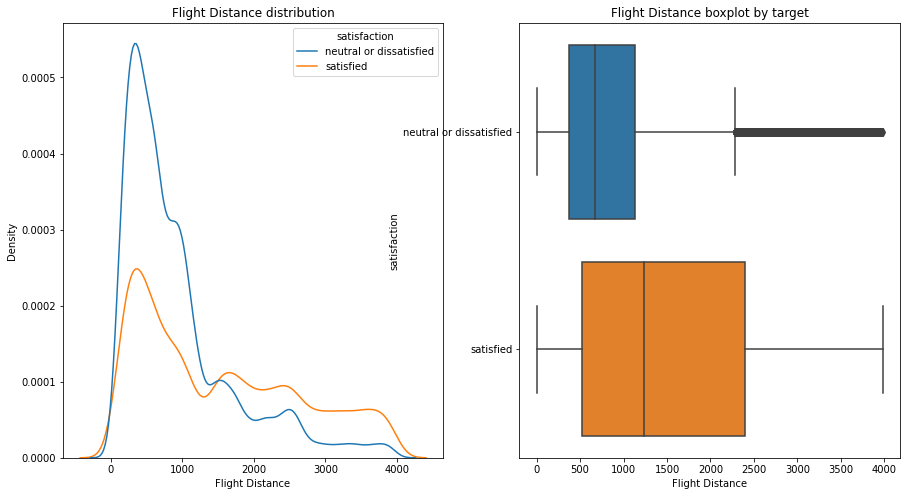

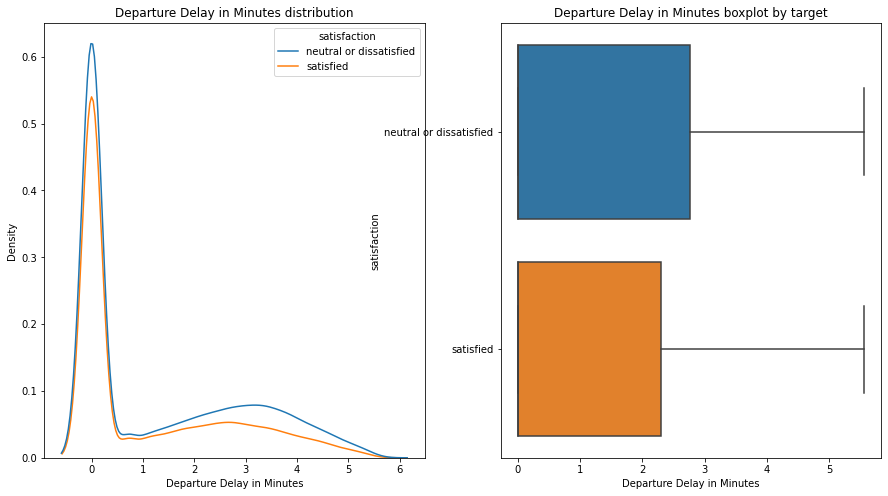

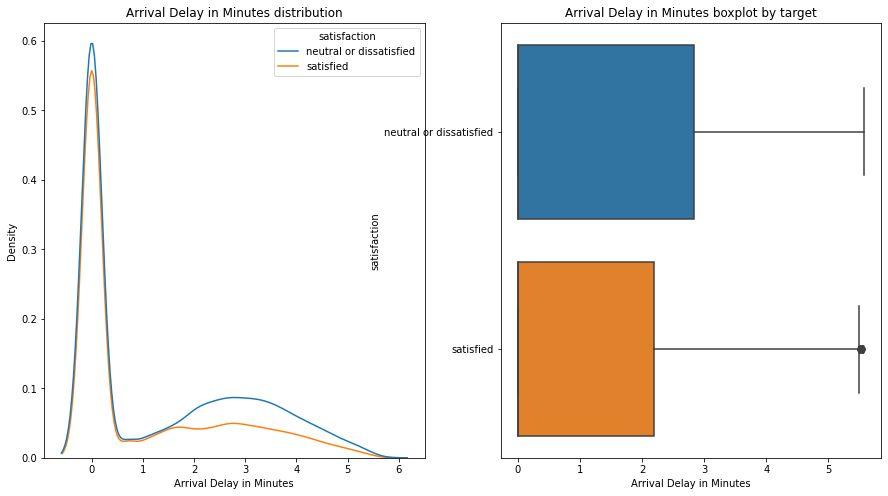

In [114]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [133]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [134]:
y_train

id
32806    0
66453    0
90663    1
68907    1
55080    0
        ..
7935     0
68680    1
96209    0
1082     0
19805    1
Name: satisfaction, Length: 71369, dtype: int64

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [135]:
df_train_merge = pd.merge(X_train, y_train, how='inner', on = 'id')

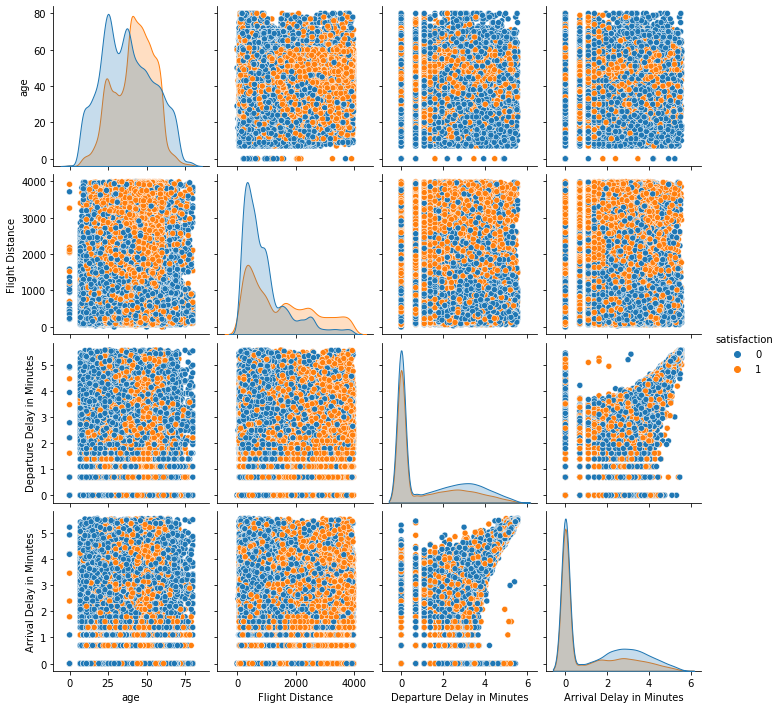

In [136]:
sns.pairplot(df_train_merge, hue='satisfaction', vars=continuous_cols);

<font color='#9933CC'>Отобразите тепловую карту корреляций признаков и таргета</font>

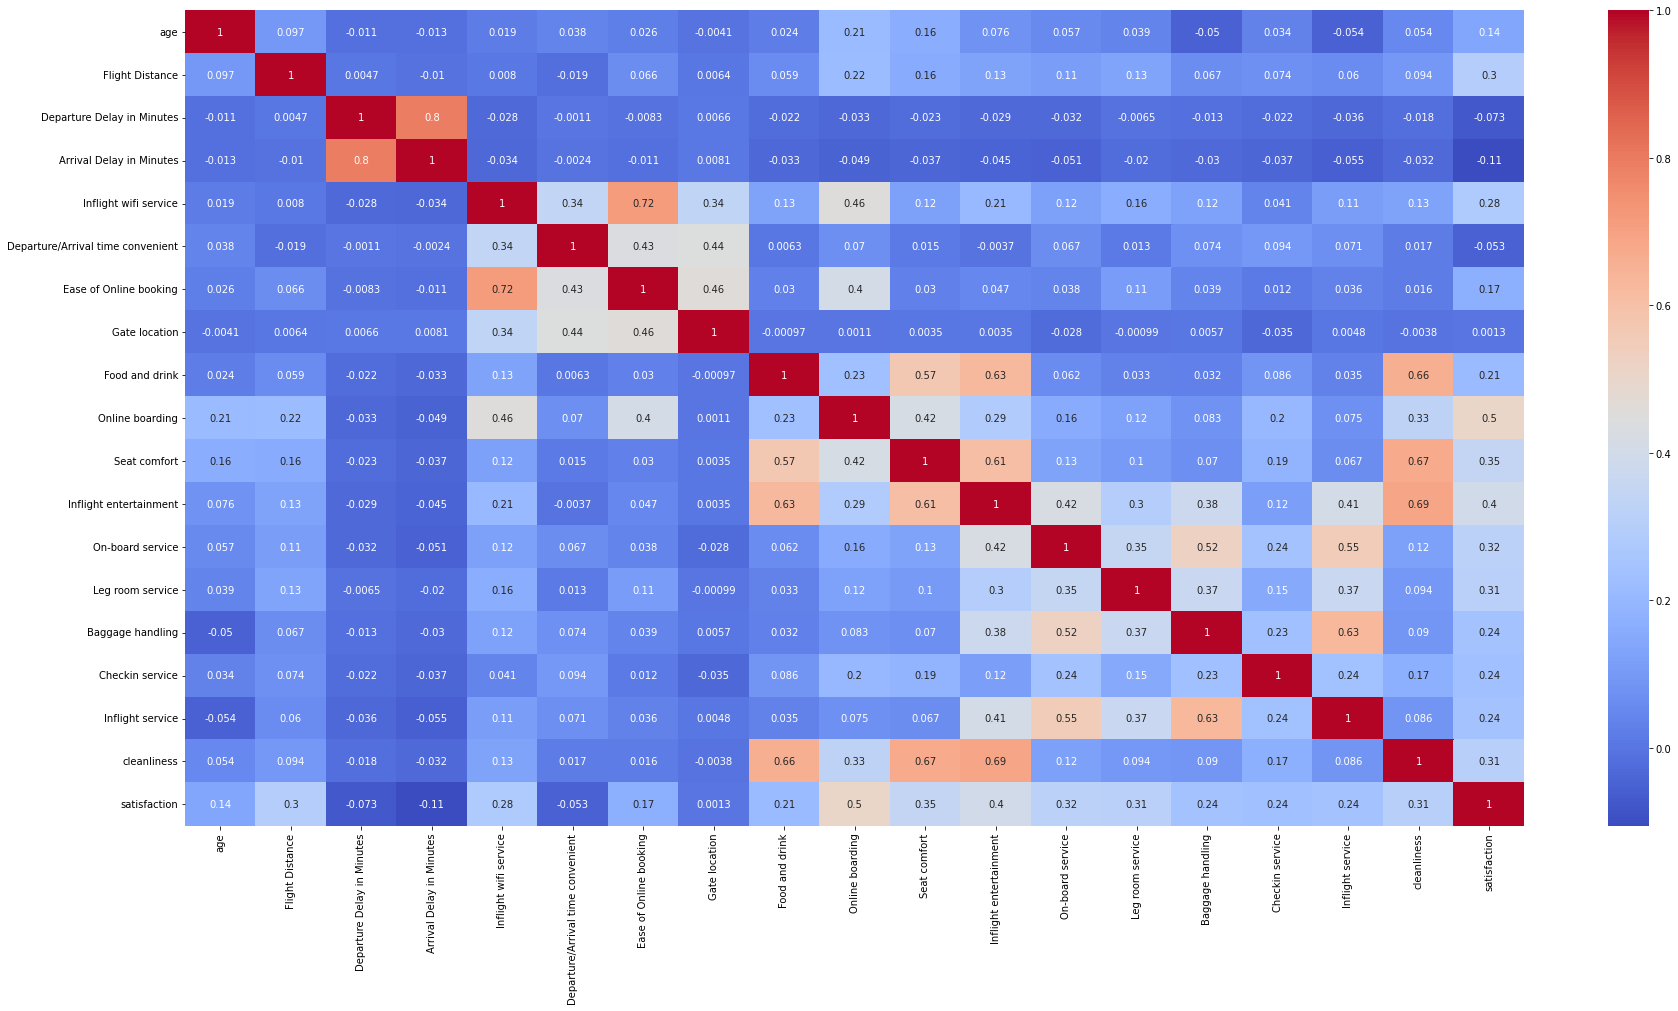

In [138]:
plt.figure(figsize=(30,15))
sns.heatmap(df_train_merge.corr(), annot = True, cmap='coolwarm');

Видим, что с целевой переменной ни у одного признака нет выраженной корреляции. Самая большая у 'Online boarding'. Дальше проверим, информативен ли этот признак для предсказания удовлетворенности

<img src='https://mobimg.b-cdn.net/v3/fetch/fe/fe22186dba2df35f07573604aa8a0e63.jpeg?w=1470&r=0.5625' height=500px>

# Decision Tree (1.75 балла)

(0.25 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [145]:
categorical_cols

['gender', 'Customer Type', 'Type of Travel', 'class']

In [147]:
from sklearn.preprocessing import OneHotEncoder

ohe=OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[categorical_cols])

X_train_enc = pd.DataFrame(ohe.transform(X_train[categorical_cols]))
X_train_enc.columns = ohe.get_feature_names_out(categorical_cols)

X_train_cat = pd.concat([X_train.reset_index().drop(categorical_cols, axis=1), X_train_enc], axis=1).set_index('id')

X_val_enc = pd.DataFrame(ohe.transform(X_val[categorical_cols]))
X_val_enc.columns = ohe.get_feature_names_out(categorical_cols)

X_val_cat = pd.concat([X_val.reset_index().drop(categorical_cols, axis=1), X_val_enc], axis=1).set_index('id')

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для теста

In [150]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train_cat, y_train)
y_pred_dt = dt.predict(X_val_cat)

In [151]:
score_dt = accuracy_score(y_val, y_pred_dt)
score_dt

0.9430551469386421

## Деревья решений. Теоретическая вставка

(0.25 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [152]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
        dt, 
        X_train_cat.values, 
        y_train.values, 
        X_val_cat.values, 
        y_val.values, 
        loss='0-1_loss',
        random_seed=42)

error_dt, bias_dt, var_dt

(0.060494426465300254, 0.03961949593017554, 0.04430306299238338)

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

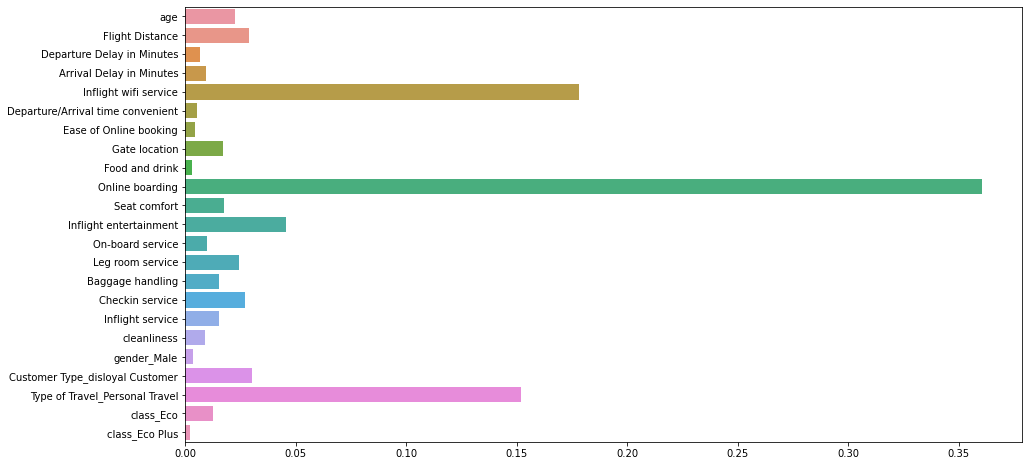

In [153]:
plt.figure(figsize=(15,8))
sns.barplot(x=dt.feature_importances_, y=X_train_cat.columns);

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Наиболее информативными являются: 
1. Online boarding
2. Inflight wifi service
3. Type of Travel_Personal Travel

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [154]:
print("Глубина дерева: ", dt.tree_.max_depth)

Глубина дерева:  35


In [155]:
print("Кол-во листьев: ", dt.tree_.n_leaves)

Кол-во листьев:  2081


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [156]:
importance_cats = ['Online boarding','Inflight wifi service']

dt_5 = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_5.fit(X_train_cat[importance_cats], y_train)
y_pred_dt_5 = dt_5.predict(X_val_cat[importance_cats])

In [158]:
score_dt_5 = accuracy_score(y_val, y_pred_dt_5)
score_dt_5

0.8217776470203655

In [159]:
print(f'Качество на val упало на {score_dt - score_dt_5}')

Качество на val упало на 0.12127749991827663


(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

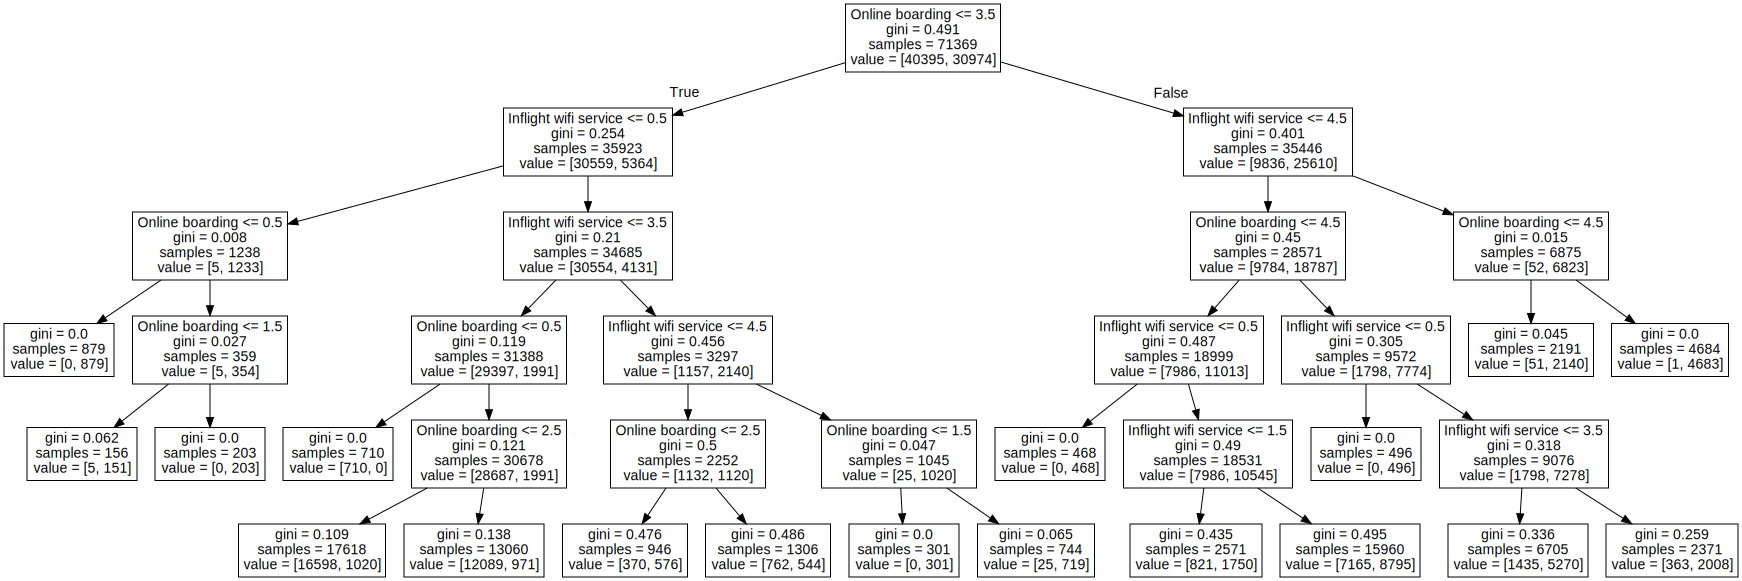

In [160]:
graphviz = export_graphviz(dt_5, feature_names = importance_cats)

graph = Source(graphviz) 
graph

Предикаты в нем не целые, а кратны 1/2, возможно, потому что берется два ближайших значения и находится их среднее.

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договореённости) признаков</font>

In [161]:
continuous_importance = ['age', 'Flight Distance']

dt_5_cont = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_5_cont.fit(X_train_cat[continuous_importance], y_train)
y_pred_dt_5_cont = dt_5_cont.predict(X_val_cat[continuous_importance])


In [162]:
score_dt_5_cont = accuracy_score(y_val, y_pred_dt_5_cont)
score_dt_5_cont

0.6809519139616227

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

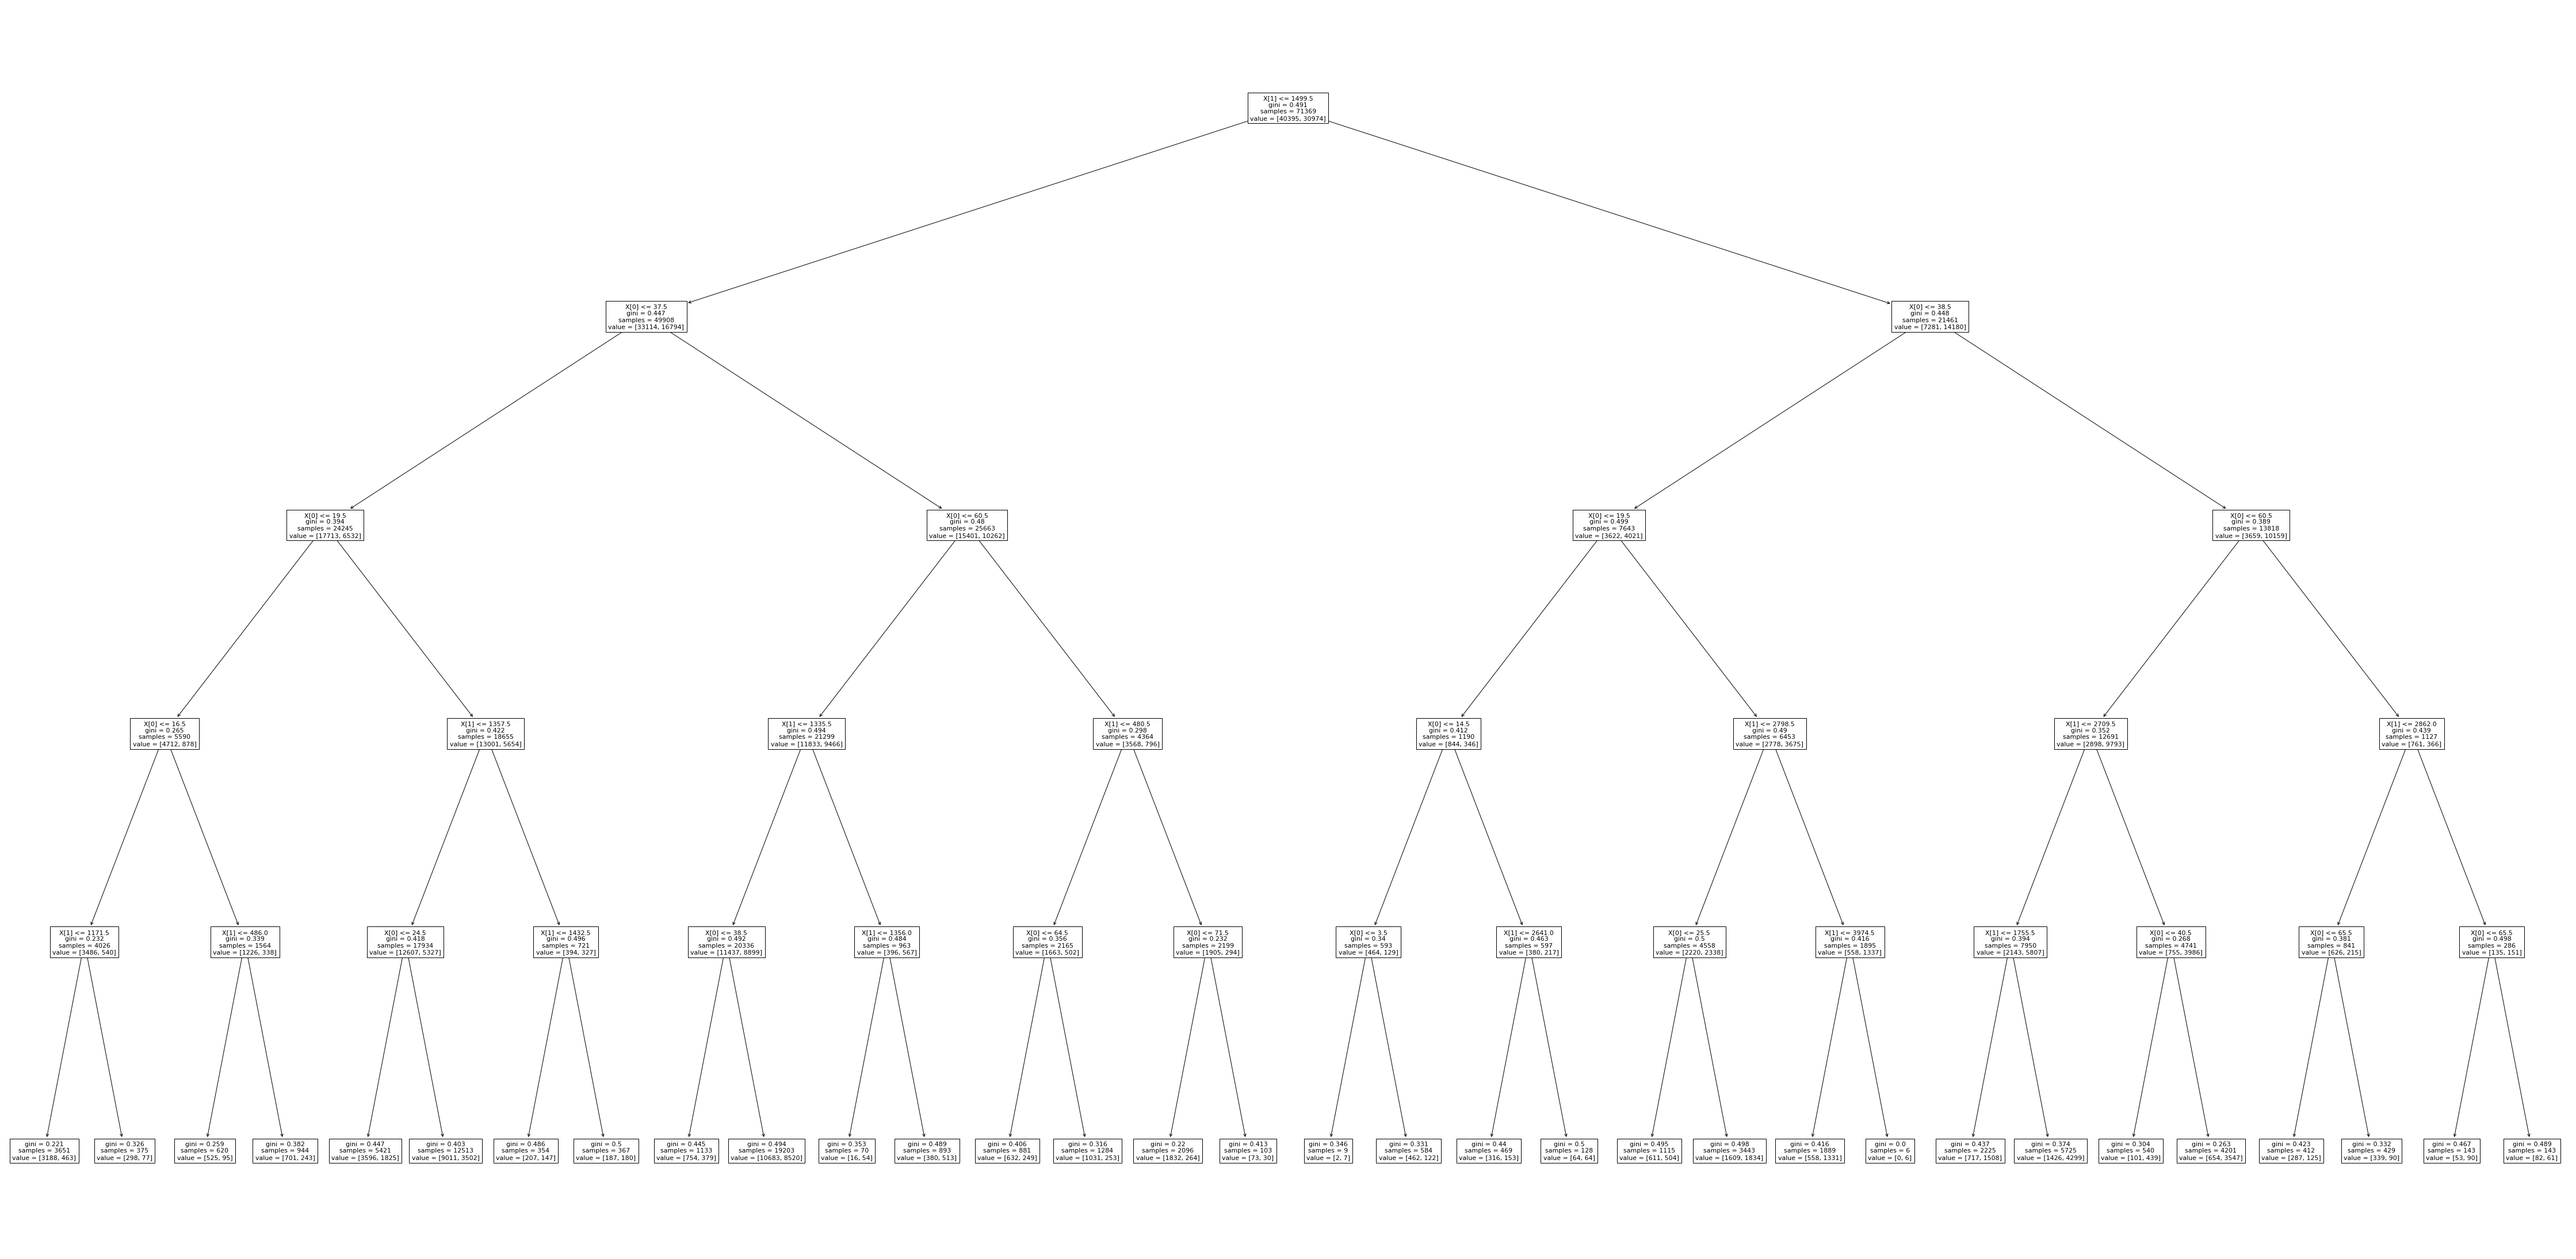

In [163]:
plt.figure(figsize=(80,40))
plot_tree(dt_5_cont);

Дерево получилось симметричным. Это хорошо потому что симметричное дерево может быть легко представлено в виде обычной таблицы с числами — матрицы, что очень важно для скорости вычислений, компьютеры справляются с такими деревьями гораздо лучше.

(0.25 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


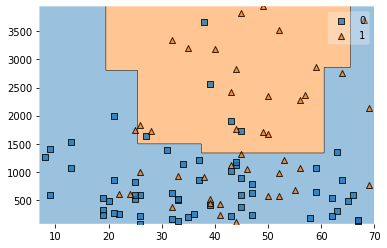

In [164]:
plot_decision_regions(X_train_cat[continuous_importance][:100].values, 
                      y_train[:100].values, 
                      dt_5_cont);

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


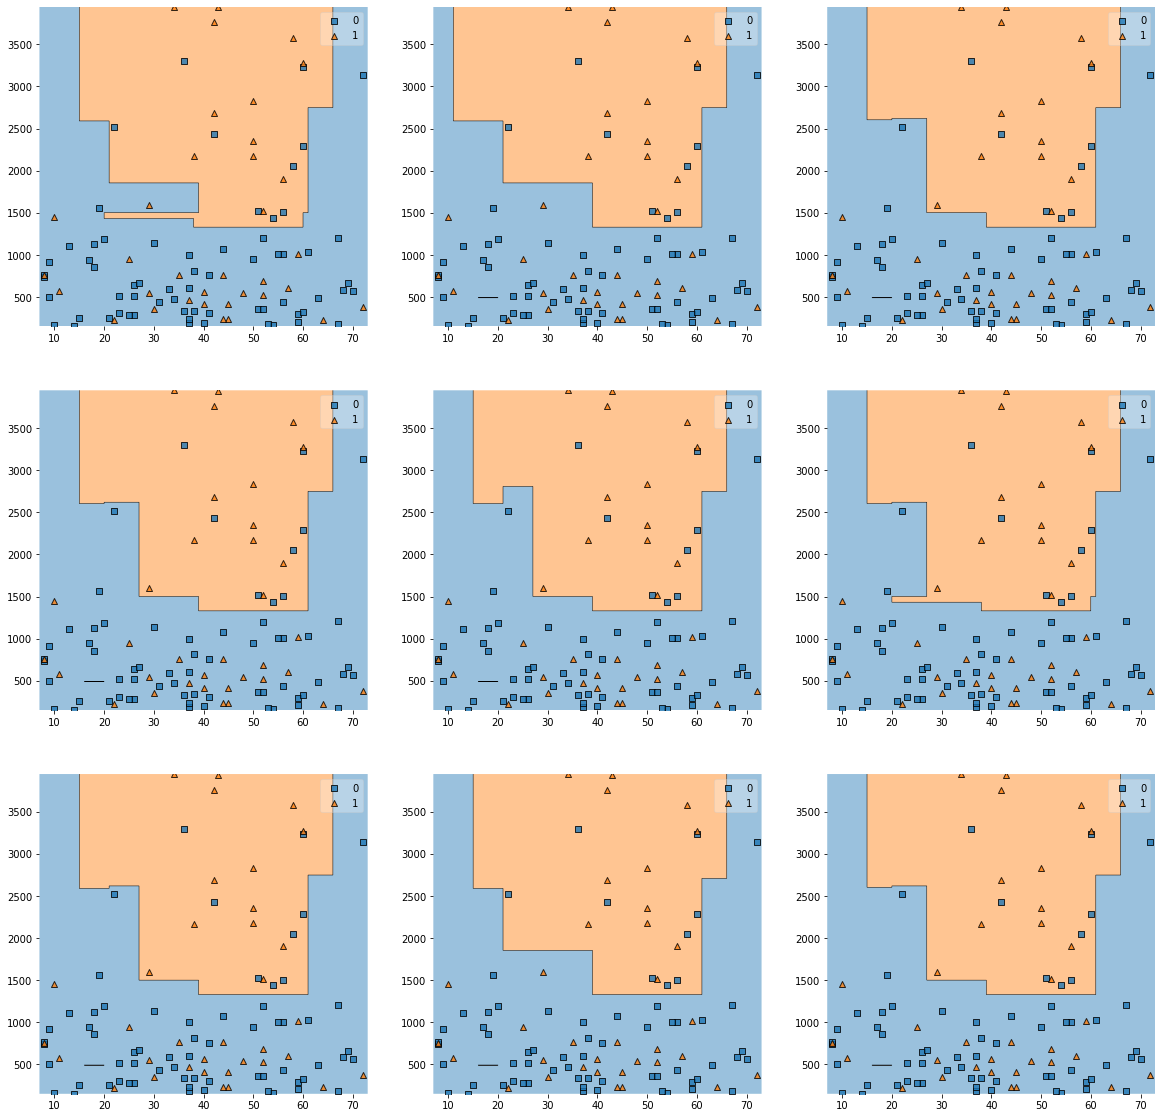

In [ ]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# change X_train_enc into your ohe-encoded train set

%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 5.84 s, sys: 22 ms, total: 5.86 s
Wall time: 5.96 s


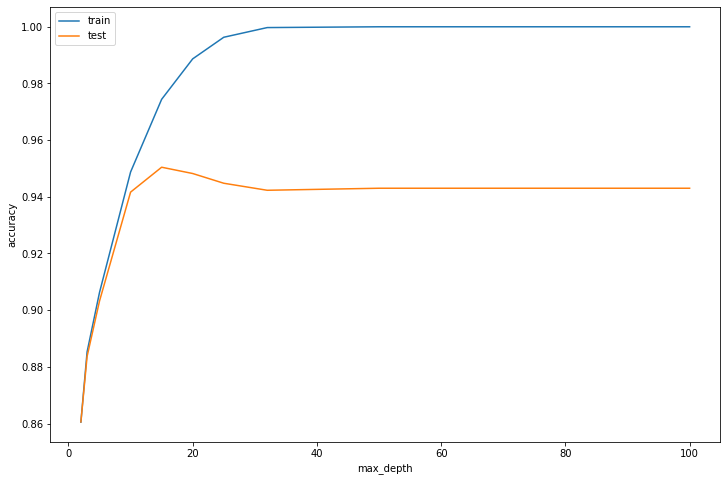

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font>. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [165]:
grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 11),
        'min_samples_leaf': range(2, 11),
        'min_samples_split': range(2, 11),
       }

dt_gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=grid, cv=3)

dt_gs.fit(X_train_cat, y_train)
y_pred_dt_search = dt_gs.predict(X_val_cat)

In [166]:
score_gs = accuracy_score(y_val, y_pred_dt_search)
score_gs

0.9458010525971691

In [167]:
print(f'Качество на val повысилось на {score_gs - score_dt}')

Качество на val повысилось на 0.002745905658526948


<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [168]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(dt_gs, f)

# Random Forest (2 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [169]:
# -__-

forest = RandomForestClassifier(random_state=42)
forest = forest.fit(X_train_cat, y_train)
y_pred_forest = forest.predict(X_val_cat)

(0.25 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

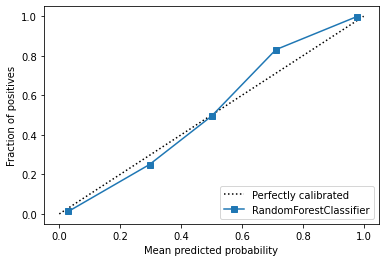

In [171]:
CalibrationDisplay.from_estimator(forest, X_val_cat, y_val);

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

Деревья некорректно предсказывают вероятности. Из классификаторов корректно предсказывает вероятности только логистическая регрессия.

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

In [172]:
# --____--

%%time
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_train_cat, y_train)
y_pred_logreg = logreg.predict(X_val_cat)

CPU times: user 23.7 s, sys: 11.6 s, total: 35.3 s
Wall time: 22.5 s


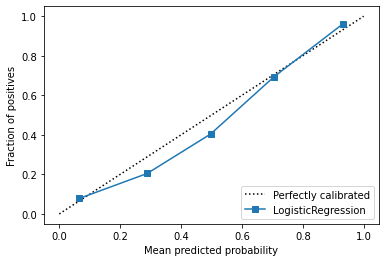

In [173]:
CalibrationDisplay.from_estimator(logreg, X_val_cat, y_val);

In [174]:
score_logreg = accuracy_score(y_val, y_pred_logreg)
score_logreg

0.875257428655487

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Евгений Соколов Лекция №6, главы 1.2 Правдоподобие и логистические потери и 1.3 Логистическая регрессия

https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture06-linclass.pdf

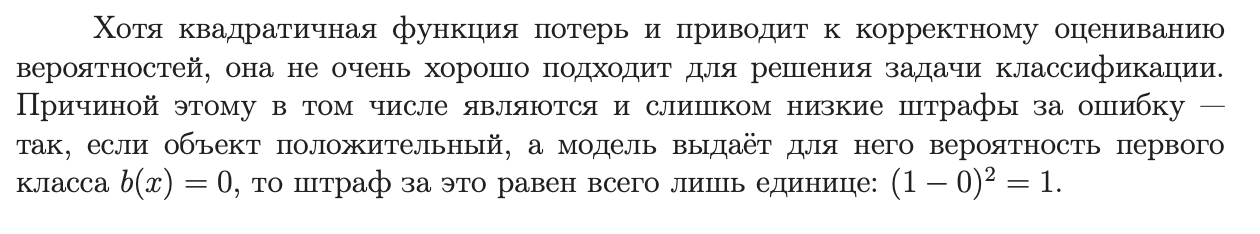

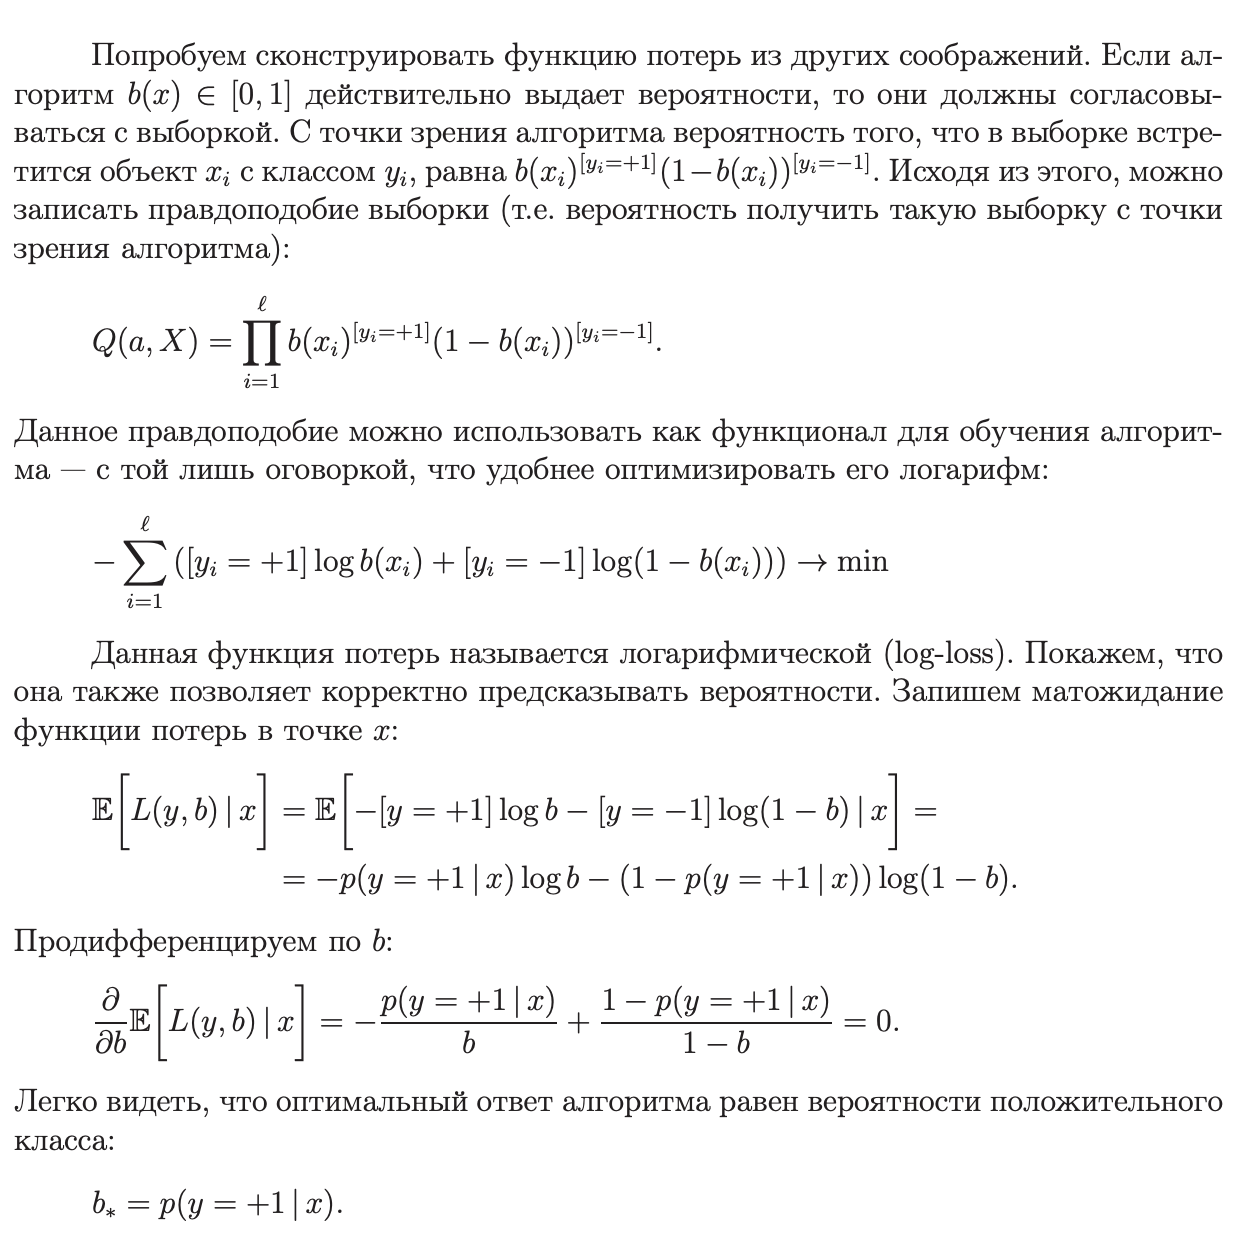

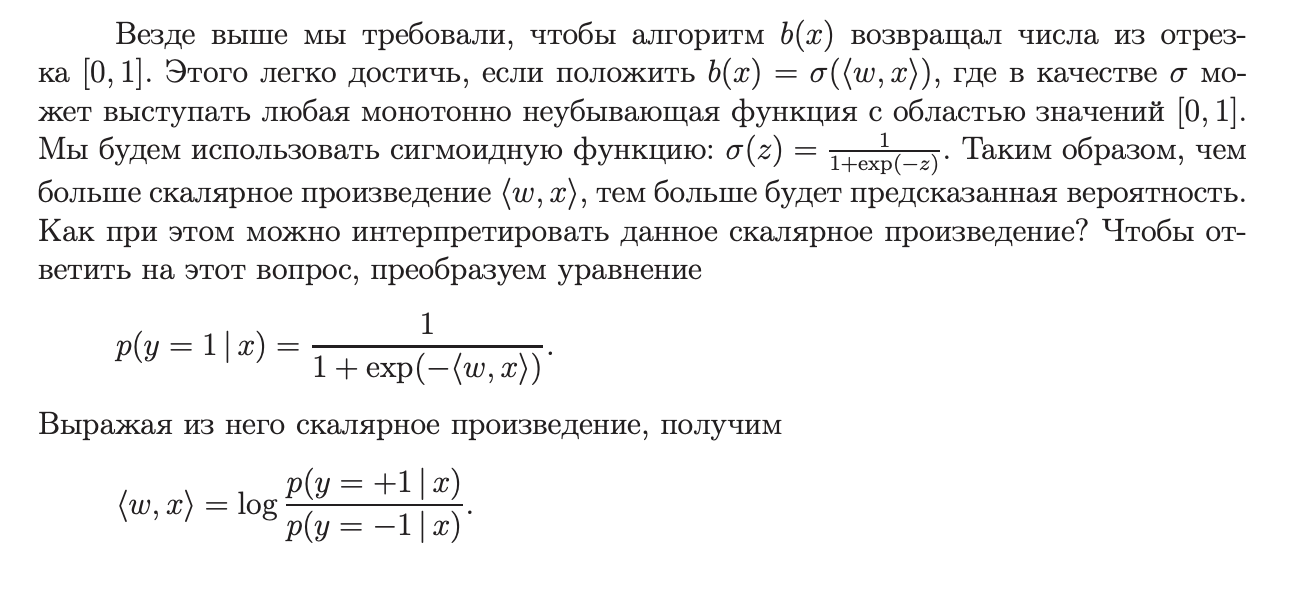

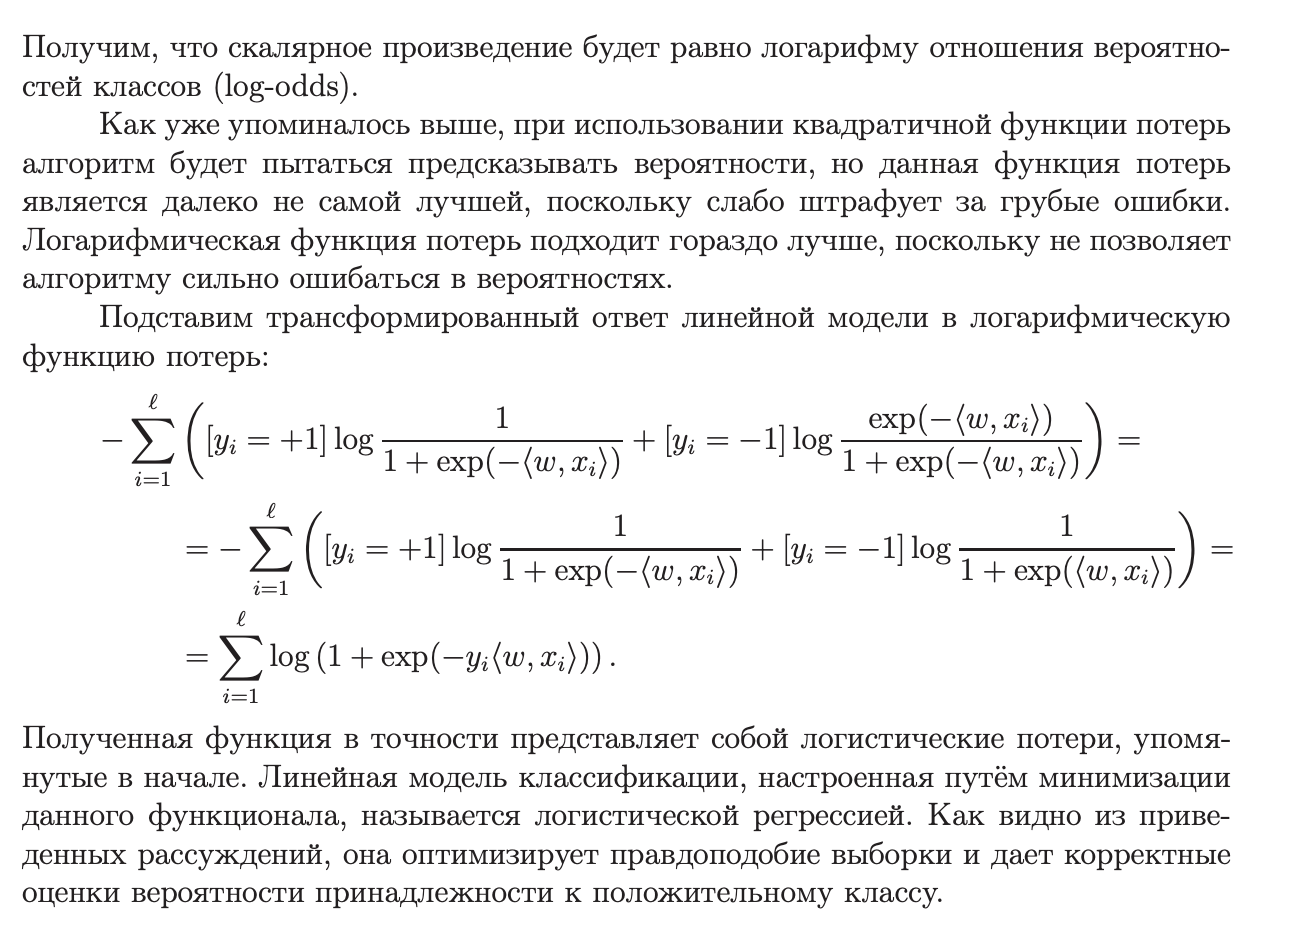

(0.25 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [175]:
from sklearn.calibration import CalibratedClassifierCV

forest_logreg = CalibratedClassifierCV(forest, cv=3, method="sigmoid")
forest_logreg.fit(X_train_cat, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=42),
                       cv=3)

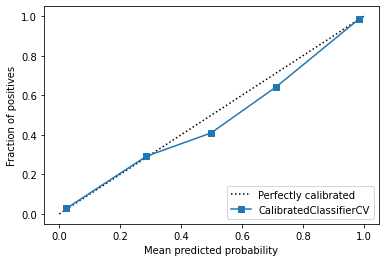

In [176]:
CalibrationDisplay.from_estimator(forest_logreg, X_val_cat, y_val);

In [177]:
forest_isotonic = CalibratedClassifierCV(forest, cv=3, method="isotonic")
forest_isotonic.fit(X_train_cat, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(random_state=42),
                       cv=3, method='isotonic')

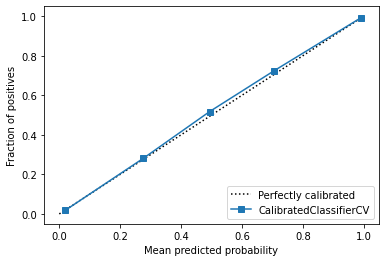

In [178]:
CalibrationDisplay.from_estimator(forest_isotonic, X_val_cat, y_val);

В нашем случае изотоническая регрессия обеспечила наилучший результат с точки зрения калибровки

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

Для калибровки можно использовать другие подходы:

- Гистограммная калибровка;
- Калибровка Платта;
- Ансамблирование;
- Сглаживание меток;
- Калибровка моделей на основе глубоких нейронных сетей и тд.

Полезные ссылки:
1. https://habr.com/ru/post/648753/
2. https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/
3. https://webiomed.ru/blog/kalibrovka-modelei-zachem-i-kak/


(0.25 балла) <font color='#9933CC'>Посчитайте разброс и смещение полученной композиции.</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [179]:
error_forest, bias_forest, var_forest = bias_variance_decomp(
        forest, 
        X_train_cat.values, 
        y_train.values, 
        X_val_cat.values, 
        y_val.values, 
        loss='0-1_loss',
        random_seed=42)

error_forest, bias_forest, var_forest


(0.04166356117812429, 0.040011768167107976, 0.009584191428851623)

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [ ]:
error_logreg, bias_logreg, var_logreg = bias_variance_decomp(
        logreg, 
        X_train_cat.values, 
        y_train.values, 
        X_val_cat.values, 
        y_val.values, 
        loss='0-1_loss',
        random_seed=42)

error_logreg, bias_logreg, var_logreg

(0.25 балла) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import uniform


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
#[10, 17, 25, 33, 41, 48, 56, 64, 72, 80]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = uniform(loc=10, scale=110)
#[int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
clf = RandomizedSearchCV(rand_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
search = clf.fit(X_train, y_train)
search.best_params_

In [ ]:
from scipy.stats import uniform

grid_rfc = {
        'max_depth': list(map(lambda x: round(x),uniform.rvs(5,50,size=10))),
        'min_samples_split': range(2,26,3),
        'min_samples_leaf': range(2,5)}
        # {'n_estimators': n_estimators,
        #        'max_features': max_features,
        #        'bootstrap': bootstrap}
clf_rfc_rand = RandomizedSearchCV(
    estimator=clf_rfc_1, param_distributions = grid_rfc,
    cv=3, random_state=42)

clf_rfc_rand.fit(X, y_train)
y_pred_rand = clf_rfc_rand.predict(X_v)
score_rand = accuracy_score(y_val, y_pred_rand)
score_rand

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_s

In [ ]:
from scipy.stats import uniform

grid_forest = {
        'max_depth': list(map(lambda x: round(x), uniform.rvs(5,50,size=10))),
        'min_samples_split': range(2,26,3),
        'min_samples_leaf': range(2,5)}
        # {'n_estimators': n_estimators,
        #        'max_features': max_features,
        #        'bootstrap': bootstrap}
forest_random = RandomizedSearchCV(
    estimator=clf_rfc_1, 
    param_distributions=grid_forest,
    cv=3, 
    random_state=42)

forest_random.fit(X_train_cat, y_train_cat)
y_pred_forest_random = forest_random.predict(X_val_cat)

In [ ]:
score_forest_random = accuracy_score(y_val_cat, y_pred_forest_random)
score_forest_random

<img src=''>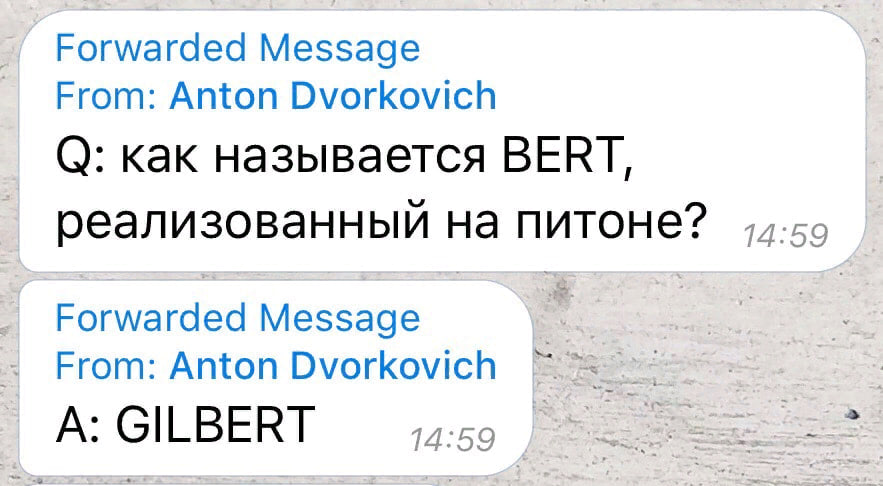

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


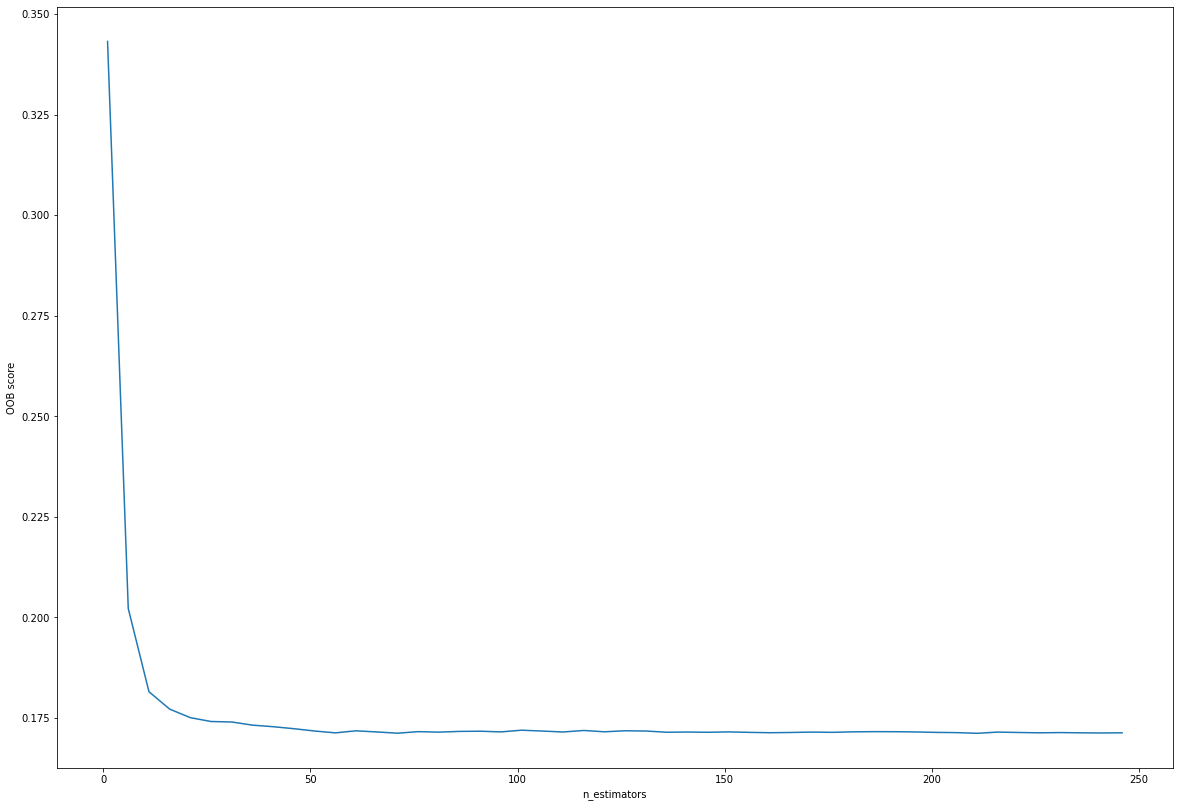

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

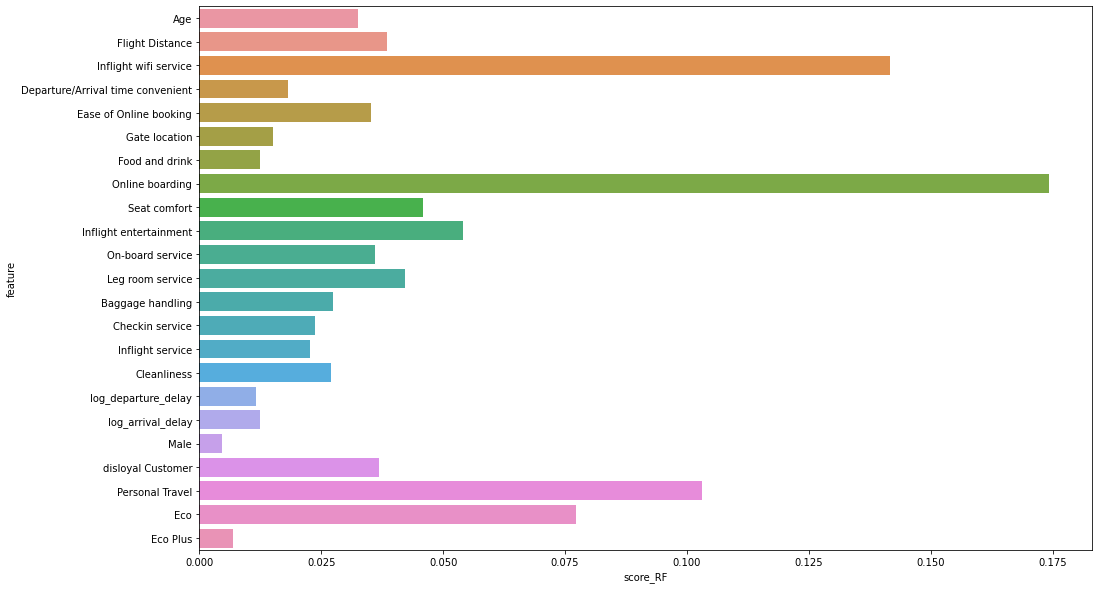

In [ ]:
# (•_•)

(0.25 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [ ]:
# -__-
feature_results_rf_best['model'] = 'rf_best'
feature_results_dt['model'] = 'dt'
feature_results_dt_rf = pd.concat([feature_results_rf_best, feature_results_dt]).reset_index()
feature_results_dt_rf.sample(5)

(0.25 балла) <font color='#9933CC'>Оцените Permutation Importance вашео случайного леса</font>. Загляните в [документацию библиотеки eli5](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)

In [ ]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(rf_best, random_state=42)
perm.fit(X_train_cat, y_train)
eli5.show_weights(perm, feature_names=X_train_cat.columns.tolist())


In [ ]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(rf_best, random_state=42)
perm.fit(X_val_cat, y_val)
eli5.show_weights(perm, feature_names=X_val_cat.columns.tolist())


In [ ]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(rf_best, random_state=42)
perm.fit(X_val, y_val)
eli5.show_weights(perm, feature_names=X_val.columns.tolist())


CPU times: user 3min 19s, sys: 1.08 s, total: 3min 21s
Wall time: 3min 35s


<font color='#FF6600'>Изучите документацию библиотеки eli5. Перечислите полезные инструменты из неё, которые вам хотелось бы попробовать: </font>

Мне бы хотелось попробовать посмотреть важность признаков для существующих моделей с помощью eli5.lightgbm, eli5.xgboost, eli5.catboost. Также в eli5 есть встроенный LIME (eli5.lime)

(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

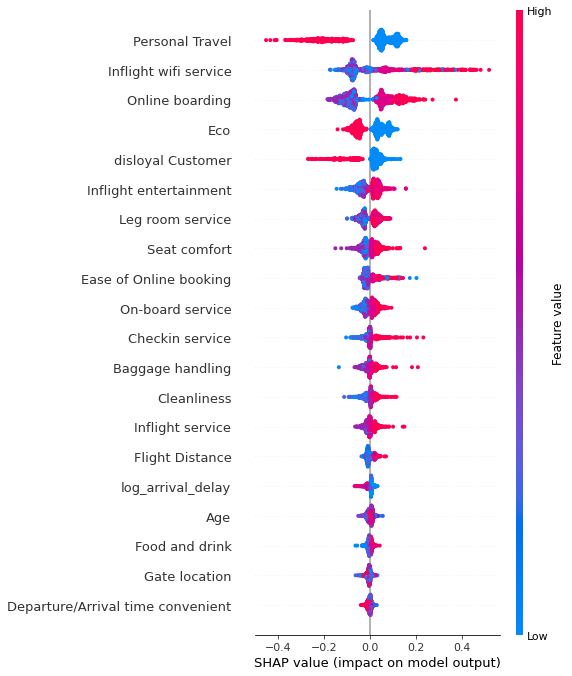

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


In [ ]:
# (•_•)


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown



(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
# please type your solution below



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


CPU times: user 13 s, sys: 918 ms, total: 13.9 s
Wall time: 16.1 s


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное дерево, дающее лучший скор, сохраните в pickle</font>

# Бустинги (1 балл)

## CatBoost (0.25 балла)

(0.25 балла) <font color='#9933CC'>Обучите pipeline из стандартизации континуальных (как договаривались) признаков и `CatBoostClassifier` с параметрами по умолчанию</font>. `StandardScaler` из sklearn не подойдет. Напишите свой собственный, который не будет изменять остальные фичи.

In [196]:
from sklearn.utils.validation import check_is_fitted

class MyStandardScaler(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, cols_to_transform):
        self.cols_to_transform = cols_to_transform

    def fit(self, X, y=None):
        self.mean_ = X[self.cols_to_transform].mean()
        self.std_ = X[self.cols_to_transform].std()

        return self

    def transform(self, X):
        check_is_fitted(self, ['mean_','std_'])
        
        X_copy = X.copy()
        X_copy[self.cols_to_transform] = (X_copy[self.cols_to_transform] - self.mean_) / self.std_

        return X_copy


In [197]:
catboost_pipe = [
    ('std_scaler', MyStandardScaler(continuous_cols)),
    ('catboost', CatBoostClassifier(random_state=42))]
    
catboost_pipeline = Pipeline(catboost_pipe)

In [201]:
catboost_pipeline.fit(X_train_cat, y_train)
y_pred_catboost = catboost_pipeline.predict(X_val_cat)

Learning rate set to 0.063736
0:	learn: 0.6071619	total: 69.7ms	remaining: 1m 9s
1:	learn: 0.5365939	total: 126ms	remaining: 1m 3s
2:	learn: 0.4577514	total: 155ms	remaining: 51.5s
3:	learn: 0.4147251	total: 181ms	remaining: 45.1s
4:	learn: 0.3805678	total: 215ms	remaining: 42.7s
5:	learn: 0.3548471	total: 245ms	remaining: 40.7s
6:	learn: 0.3340210	total: 305ms	remaining: 43.2s
7:	learn: 0.3104138	total: 338ms	remaining: 41.9s
8:	learn: 0.2913093	total: 360ms	remaining: 39.7s
9:	learn: 0.2728449	total: 387ms	remaining: 38.3s
10:	learn: 0.2592807	total: 418ms	remaining: 37.6s
11:	learn: 0.2450088	total: 439ms	remaining: 36.1s
12:	learn: 0.2339029	total: 463ms	remaining: 35.1s
13:	learn: 0.2270759	total: 484ms	remaining: 34.1s
14:	learn: 0.2195840	total: 506ms	remaining: 33.2s
15:	learn: 0.2121964	total: 528ms	remaining: 32.5s
16:	learn: 0.2041338	total: 549ms	remaining: 31.8s
17:	learn: 0.1982055	total: 570ms	remaining: 31.1s
18:	learn: 0.1933180	total: 592ms	remaining: 30.6s
19:	learn:

In [202]:
score_catboost = accuracy_score(y_val, y_pred_catboost)
score_catboost

0.9621457291360204

<font color='#9933CC'>Сохраните себе `feature_importances_` катбуста</font>. Дальше они вам пригодятся

In [203]:
# (•_•)
with open('catboost_feature_importances_.pkl', 'wb') as f:
    pickle.dump(catboost_pipeline.named_steps['catboost'].feature_importances_, f)

## XGBoost + optuna (0.5 балла)

<font color='#9933CC'>Обучите `XGBClassifier` с параметрами по умолчанию</font>

In [216]:
xgb_pipe = [
    ('std_scaler', MyStandardScaler(continuous_cols)),
    ('xgb', XGBClassifier(random_state=42))]
    
xgb_pipeline = Pipeline(xgb_pipe)

In [217]:
xgb_pipeline.fit(X_train_cat, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val_cat)

In [218]:
score_xgb = accuracy_score(y_val, y_pred_xgb)
score_xgb

0.9355365957307705

(0.5 балла) <font color='#9933CC'>Оптуной подберите лучшие гиперпараметры для XGBoost</font> 

Полезные ссылки: [тык1](https://optuna.readthedocs.io/en/stable/), [тык2](https://habr.com/ru/post/704432/)

По настройкам параметров еще здесь: 

https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407

https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna

In [240]:
from xgboost import DMatrix, train 

def objective(trial):
    dtrain = DMatrix(X_train_cat, label=y_train)
    dtest = DMatrix(X_val_cat, label=y_val)

    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [300, 500, 800, 1000])
    }

    if param["booster"] == "gbtree":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)

    return accuracy


In [241]:
%%time
study = optuna.create_study(study_name="xgboost", direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-02-12 20:54:25,414] A new study created in memory with name: xgboost
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[0]	validation-auc:0.950041
[1]	validation-auc:0.950041
[2]	validation-auc:0.950041
[3]	validation-auc:0.950041
[4]	validation-auc:0.950041
[5]	validation-auc:0.950041
[6]	validation-auc:0.951239
[7]	validation-auc:0.951932
[8]	validation-auc:0.951338
[9]	validation-auc:0.95205


[I 2023-02-12 20:54:26,585] Trial 0 finished with value: 0.8971919845706253 and parameters: {'booster': 'gbtree', 'lambda': 5.1139054692169996e-08, 'alpha': 0.4919465373115223, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 4, 'eta': 0.0001869107192280892, 'gamma': 1.9230376514055e-05, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[0]	validation-auc:0.832205
[1]	validation-auc:0.840864
[2]	validation-auc:0.848022
[3]	validation-auc:0.853601
[4]	validation-auc:0.858028
[5]	validation-auc:0.861629
[6]	validation-auc:0.864586
[7]	validation-auc:0.867045
[8]	validation-auc:0.86909
[9]	validation-auc:0.870808


[I 2023-02-12 20:54:27,432] Trial 1 finished with value: 0.7833022784479096 and parameters: {'booster': 'gblinear', 'lambda': 3.917961244853691e-05, 'alpha': 0.0071953253419706755, 'learning_rate': 0.02, 'n_estimators': 300}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[0]	validation-auc:0.833177
[1]	validation-auc:0.840041
[2]	validation-auc:0.845947
[3]	validation-auc:0.850994
[4]	validation-auc:0.855274
[5]	validation-auc:0.858898
[6]	validation-auc:0.861969
[7]	validation-auc:0.864584
[8]	validation-auc:0.866819
[9]	validation-auc:0.868745


[I 2023-02-12 20:54:28,256] Trial 2 finished with value: 0.7608120035304501 and parameters: {'booster': 'gblinear', 'lambda': 2.167164254833721e-08, 'alpha': 5.791058443369445e-06, 'learning_rate': 0.014, 'n_estimators': 800}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[0]	validation-auc:0.635332
[1]	validation-auc:0.634137
[2]	validation-auc:0.634576
[3]	validation-auc:0.636
[4]	validation-auc:0.637941
[5]	validation-auc:0.640059
[6]	validation-auc:0.642198
[7]	validation-auc:0.644278
[8]	validation-auc:0.646267
[9]	validation-auc:0.648164


[I 2023-02-12 20:54:29,056] Trial 3 finished with value: 0.5886044915171129 and parameters: {'booster': 'gblinear', 'lambda': 3.630511453902323e-08, 'alpha': 0.1397245885478663, 'learning_rate': 0.016, 'n_estimators': 500}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[0]	validation-auc:0.834614
[1]	validation-auc:0.843002
[2]	validation-auc:0.84988
[3]	validation-auc:0.855452
[4]	validation-auc:0.859952
[5]	validation-auc:0.863593
[6]	validation-auc:0.866562
[7]	validation-auc:0.869012
[8]	validation-auc:0.871056
[9]	validation-auc:0.872785


[I 2023-02-12 20:54:29,829] Trial 4 finished with value: 0.7780392926023993 and parameters: {'booster': 'gblinear', 'lambda': 2.1162851221151156e-07, 'alpha': 4.3352392460162067e-05, 'learning_rate': 0.018, 'n_estimators': 500}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:54:29,971] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-auc:0.83462
[1]	validation-auc:0.843009
[2]	validation-auc:0.849889
[3]	validation-auc:0.855462
[4]	validation-auc:0.859962
[5]	validation-auc:0.863603
[6]	validation-auc:0.866573
[7]	validation-auc:0.869023
[8]	validation-auc:0.871066
[9]	validation-auc:0.872795


[I 2023-02-12 20:54:30,501] Trial 6 finished with value: 0.7780066032493217 and parameters: {'booster': 'gblinear', 'lambda': 6.210122299520115e-07, 'alpha': 1.8207254328136998e-05, 'learning_rate': 0.018, 'n_estimators': 300}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/op

[0]	validation-auc:0.92092
[1]	validation-auc:0.92092
[2]	validation-auc:0.92092
[3]	validation-auc:0.92092
[4]	validation-auc:0.92092
[5]	validation-auc:0.92092
[6]	validation-auc:0.92092
[7]	validation-auc:0.92092
[8]	validation-auc:0.92765
[9]	validation-auc:0.926748


[I 2023-02-12 20:54:31,335] Trial 7 finished with value: 0.8836585923964565 and parameters: {'booster': 'gbtree', 'lambda': 5.216403532633259e-06, 'alpha': 7.84255432009191e-08, 'learning_rate': 0.018, 'n_estimators': 500, 'max_depth': 3, 'eta': 0.00010090167951407263, 'gamma': 0.17922384104179756, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8971919845706253.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:54:31,491] Trial 8 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

[0]	validation-auc:0.96507
[1]	validation-auc:0.96507
[2]	validation-auc:0.96507
[3]	validation-auc:0.96507
[4]	validation-auc:0.96507
[5]	validation-auc:0.965071
[6]	validation-auc:0.965515
[7]	validation-auc:0.965358
[8]	validation-auc:0.966463
[9]	validation-auc:0.966617


[I 2023-02-12 20:54:32,660] Trial 9 finished with value: 0.9032395148900003 and parameters: {'booster': 'gbtree', 'lambda': 1.7115506271475845e-06, 'alpha': 0.20587168637802186, 'learning_rate': 0.018, 'n_estimators': 300, 'max_depth': 5, 'eta': 2.1364081586989754e-08, 'gamma': 0.7950155732159416, 'grow_policy': 'depthwise'}. Best is trial 9 with value: 0.9032395148900003.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.984735
[1]	validation-auc:0.984991
[2]	validation-auc:0.985044
[3]	validation-auc:0.985074
[4]	validation-auc:0.985208
[5]	validation-auc:0.985414
[6]	validation-auc:0.985745
[7]	validation-auc:0.985802
[8]	validation-auc:0.986045
[9]	validation-auc:0.986172


[I 2023-02-12 20:54:35,579] Trial 10 finished with value: 0.9419763982870779 and parameters: {'booster': 'gbtree', 'lambda': 0.0009220373810359263, 'alpha': 0.001536320971883951, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 10, 'eta': 1.0717562585590259e-08, 'gamma': 0.21363862238616127, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_lo

[0]	validation-auc:0.984744
[1]	validation-auc:0.984878
[2]	validation-auc:0.984955
[3]	validation-auc:0.984952
[4]	validation-auc:0.985008
[5]	validation-auc:0.985231
[6]	validation-auc:0.985534
[7]	validation-auc:0.985604
[8]	validation-auc:0.985829
[9]	validation-auc:0.985977


[I 2023-02-12 20:54:38,486] Trial 11 finished with value: 0.9419763982870779 and parameters: {'booster': 'gbtree', 'lambda': 0.000552434647492295, 'alpha': 0.002264414991828003, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 10, 'eta': 1.6987653832165482e-08, 'gamma': 0.4915591681468692, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logu

[0]	validation-auc:0.984762
[1]	validation-auc:0.984945
[2]	validation-auc:0.985103
[3]	validation-auc:0.985144
[4]	validation-auc:0.985196
[5]	validation-auc:0.985409
[6]	validation-auc:0.985741
[7]	validation-auc:0.985728
[8]	validation-auc:0.985981
[9]	validation-auc:0.986129


[I 2023-02-12 20:54:42,223] Trial 12 finished with value: 0.9419763982870779 and parameters: {'booster': 'gbtree', 'lambda': 0.0006220505082232931, 'alpha': 0.001692540925832351, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 10, 'eta': 1.2860365103842283e-08, 'gamma': 0.018553134617301525, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_l

[0]	validation-auc:0.984848
[1]	validation-auc:0.985115
[2]	validation-auc:0.985123
[3]	validation-auc:0.985122
[4]	validation-auc:0.985201
[5]	validation-auc:0.985432
[6]	validation-auc:0.985732
[7]	validation-auc:0.985747
[8]	validation-auc:0.985961
[9]	validation-auc:0.986097


[I 2023-02-12 20:54:45,554] Trial 13 finished with value: 0.9419763982870779 and parameters: {'booster': 'gbtree', 'lambda': 0.00148092021139486, 'alpha': 0.0009904157865706592, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 10, 'eta': 2.2903967513442842e-07, 'gamma': 0.001984246167893273, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_lo

[0]	validation-auc:0.982366
[1]	validation-auc:0.982712
[2]	validation-auc:0.98277
[3]	validation-auc:0.982716
[4]	validation-auc:0.98284
[5]	validation-auc:0.983648
[6]	validation-auc:0.983668
[7]	validation-auc:0.983733
[8]	validation-auc:0.983652
[9]	validation-auc:0.983842


[I 2023-02-12 20:54:47,683] Trial 14 finished with value: 0.934817429963061 and parameters: {'booster': 'gbtree', 'lambda': 0.25166218067173424, 'alpha': 0.0005455986549748963, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 8, 'eta': 0.07099192650833916, 'gamma': 1.7301896677559838e-07, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logun

[0]	validation-auc:0.978407
[1]	validation-auc:0.978459
[2]	validation-auc:0.978453
[3]	validation-auc:0.978456
[4]	validation-auc:0.978856
[5]	validation-auc:0.978888
[6]	validation-auc:0.979016
[7]	validation-auc:0.979053
[8]	validation-auc:0.979655
[9]	validation-auc:0.979663


[I 2023-02-12 20:54:49,437] Trial 15 finished with value: 0.9246183518028178 and parameters: {'booster': 'gbtree', 'lambda': 0.0021829228669365606, 'alpha': 0.008690052800259196, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 7, 'eta': 8.514114343040149e-07, 'gamma': 0.6157589566598193, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logun

[0]	validation-auc:0.982217
[1]	validation-auc:0.98229
[2]	validation-auc:0.982638
[3]	validation-auc:0.982649
[4]	validation-auc:0.982633
[5]	validation-auc:0.98264
[6]	validation-auc:0.983023
[7]	validation-auc:0.983459
[8]	validation-auc:0.983464
[9]	validation-auc:0.983565


[I 2023-02-12 20:54:51,842] Trial 17 finished with value: 0.9335425451930306 and parameters: {'booster': 'gbtree', 'lambda': 0.009186672476484609, 'alpha': 0.010430536784561415, 'learning_rate': 0.008, 'n_estimators': 800, 'max_depth': 8, 'eta': 1.3010465542605169e-06, 'gamma': 0.024657783438093443, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.9419763982870779.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logu

[0]	validation-auc:0.984956
[1]	validation-auc:0.984836
[2]	validation-auc:0.985015
[3]	validation-auc:0.985011
[4]	validation-auc:0.98508
[5]	validation-auc:0.985306
[6]	validation-auc:0.985611
[7]	validation-auc:0.985607
[8]	validation-auc:0.985844
[9]	validation-auc:0.98598


[I 2023-02-12 20:54:55,606] Trial 18 finished with value: 0.9420090876401556 and parameters: {'booster': 'gbtree', 'lambda': 0.0003673907518033893, 'alpha': 0.00018880723928616324, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 10, 'eta': 3.721649549880195e-06, 'gamma': 0.0003306420433993986, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.9420090876401556.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest

[0]	validation-auc:0.98202
[1]	validation-auc:0.982485
[2]	validation-auc:0.982521
[3]	validation-auc:0.982859
[4]	validation-auc:0.983453
[5]	validation-auc:0.983437
[6]	validation-auc:0.983538
[7]	validation-auc:0.983688
[8]	validation-auc:0.983675
[9]	validation-auc:0.983842


[I 2023-02-12 20:54:58,098] Trial 19 finished with value: 0.9347520512569056 and parameters: {'booster': 'gbtree', 'lambda': 2.274837448062318e-05, 'alpha': 4.457493307078754e-06, 'learning_rate': 0.014, 'n_estimators': 1000, 'max_depth': 8, 'eta': 3.5612863320206503e-06, 'gamma': 0.00013757279036206353, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.9420090876401556.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest

[0]	validation-auc:0.984778
[1]	validation-auc:0.985026
[2]	validation-auc:0.985159
[3]	validation-auc:0.985105
[4]	validation-auc:0.985236
[5]	validation-auc:0.985443
[6]	validation-auc:0.985713
[7]	validation-auc:0.985758
[8]	validation-auc:0.985981
[9]	validation-auc:0.986154


[I 2023-02-12 20:55:01,372] Trial 21 finished with value: 0.9419763982870779 and parameters: {'booster': 'gbtree', 'lambda': 0.00015166614543512123, 'alpha': 0.003123497556659879, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 10, 'eta': 1.2220113984980205e-07, 'gamma': 0.058752362523301335, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.9420090876401556.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_

[0]	validation-auc:0.983352
[1]	validation-auc:0.98345
[2]	validation-auc:0.983681
[3]	validation-auc:0.983814
[4]	validation-auc:0.983819
[5]	validation-auc:0.98428
[6]	validation-auc:0.984273
[7]	validation-auc:0.984357
[8]	validation-auc:0.984486
[9]	validation-auc:0.984502


[I 2023-02-12 20:55:03,858] Trial 22 finished with value: 0.9390670458631624 and parameters: {'booster': 'gbtree', 'lambda': 0.0034089069149767187, 'alpha': 0.0003379701766390484, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 9, 'eta': 1.0412917070092399e-07, 'gamma': 0.8782976670555824, 'grow_policy': 'depthwise'}. Best is trial 18 with value: 0.9420090876401556.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_log

[0]	validation-auc:0.983713
[1]	validation-auc:0.983726
[2]	validation-auc:0.984011
[3]	validation-auc:0.984027
[4]	validation-auc:0.984033
[5]	validation-auc:0.984508
[6]	validation-auc:0.984483
[7]	validation-auc:0.984532
[8]	validation-auc:0.984666
[9]	validation-auc:0.984665


[I 2023-02-12 20:55:06,393] Trial 23 finished with value: 0.9390670458631624 and parameters: {'booster': 'gbtree', 'lambda': 0.000614154873105357, 'alpha': 0.03272913817828807, 'learning_rate': 0.008, 'n_estimators': 1000, 'max_depth': 9, 'eta': 9.959777102303425e-08, 'gamma': 0.11065314502800175, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.9420090876401556.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguni

[0]	validation-auc:0.984884
[1]	validation-auc:0.984938
[2]	validation-auc:0.985044
[3]	validation-auc:0.985031
[4]	validation-auc:0.985647
[5]	validation-auc:0.985716
[6]	validation-auc:0.985887
[7]	validation-auc:0.986157
[8]	validation-auc:0.986235
[9]	validation-auc:0.986315


[I 2023-02-12 20:55:10,446] Trial 24 finished with value: 0.9431532149978752 and parameters: {'booster': 'gbtree', 'lambda': 0.00016969781602058277, 'alpha': 0.0012406958963260986, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 10, 'eta': 1.047678817419217e-05, 'gamma': 0.0032550807737256877, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.9431532149978752.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest

[0]	validation-auc:0.983439
[1]	validation-auc:0.983381
[2]	validation-auc:0.98385
[3]	validation-auc:0.983839
[4]	validation-auc:0.98436
[5]	validation-auc:0.984479
[6]	validation-auc:0.984552
[7]	validation-auc:0.98471
[8]	validation-auc:0.984817
[9]	validation-auc:0.984878


[I 2023-02-12 20:55:12,931] Trial 25 finished with value: 0.9388055310385407 and parameters: {'booster': 'gbtree', 'lambda': 1.5403334116885463e-05, 'alpha': 8.544288035194359e-05, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 9, 'eta': 1.5203641263228145e-05, 'gamma': 0.0021595375912393366, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.9431532149978752.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest

[0]	validation-auc:0.983557
[1]	validation-auc:0.983651
[2]	validation-auc:0.983984
[3]	validation-auc:0.984012
[4]	validation-auc:0.984481
[5]	validation-auc:0.98447
[6]	validation-auc:0.984529
[7]	validation-auc:0.984627
[8]	validation-auc:0.984795
[9]	validation-auc:0.984792


[I 2023-02-12 20:55:15,774] Trial 27 finished with value: 0.9377594717400543 and parameters: {'booster': 'gbtree', 'lambda': 4.171733252868386e-05, 'alpha': 0.029098068628719227, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 9, 'eta': 3.075237487746853e-06, 'gamma': 0.007389546714566109, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.9431532149978752.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logu

[0]	validation-auc:0.985563
[1]	validation-auc:0.985666
[2]	validation-auc:0.985912
[3]	validation-auc:0.985984
[4]	validation-auc:0.986254
[5]	validation-auc:0.986553
[6]	validation-auc:0.986738
[7]	validation-auc:0.986874
[8]	validation-auc:0.986849
[9]	validation-auc:0.987023


[I 2023-02-12 20:55:18,995] Trial 29 finished with value: 0.9437743127063516 and parameters: {'booster': 'gbtree', 'lambda': 0.009623200728129494, 'alpha': 0.623211792502016, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 10, 'eta': 3.597939098357294e-07, 'gamma': 0.009710012547878765, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguni

[0]	validation-auc:0.985186
[1]	validation-auc:0.985331
[2]	validation-auc:0.985464
[3]	validation-auc:0.98548
[4]	validation-auc:0.986029
[5]	validation-auc:0.986158
[6]	validation-auc:0.986278
[7]	validation-auc:0.986464
[8]	validation-auc:0.986571
[9]	validation-auc:0.986675


[I 2023-02-12 20:55:23,192] Trial 31 finished with value: 0.9429897682324867 and parameters: {'booster': 'gbtree', 'lambda': 0.0015353342477038635, 'alpha': 0.02468368518503241, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 10, 'eta': 4.243842822117536e-07, 'gamma': 0.010076507009683128, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_log

[0]	validation-auc:0.984104
[1]	validation-auc:0.984327
[2]	validation-auc:0.984335
[3]	validation-auc:0.984508
[4]	validation-auc:0.985016
[5]	validation-auc:0.985105
[6]	validation-auc:0.985133
[7]	validation-auc:0.985181
[8]	validation-auc:0.985199
[9]	validation-auc:0.985526


[I 2023-02-12 20:55:25,783] Trial 32 finished with value: 0.9376614036808212 and parameters: {'booster': 'gbtree', 'lambda': 0.004093748221447479, 'alpha': 0.5336657382400354, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 9, 'eta': 1.9148037541697942e-06, 'gamma': 0.009283874870060755, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logun

[0]	validation-auc:0.985634
[1]	validation-auc:0.985825
[2]	validation-auc:0.985799
[3]	validation-auc:0.985868
[4]	validation-auc:0.986107
[5]	validation-auc:0.986428
[6]	validation-auc:0.986576
[7]	validation-auc:0.986673
[8]	validation-auc:0.986815
[9]	validation-auc:0.986822


[I 2023-02-12 20:55:28,708] Trial 33 finished with value: 0.9436762446471184 and parameters: {'booster': 'gbtree', 'lambda': 0.07047879526229921, 'alpha': 0.3257809595512049, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 10, 'eta': 5.386909573873386e-07, 'gamma': 0.0008791449798705127, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logun

[0]	validation-auc:0.984013
[1]	validation-auc:0.984067
[2]	validation-auc:0.984324
[3]	validation-auc:0.984381
[4]	validation-auc:0.984813
[5]	validation-auc:0.98484
[6]	validation-auc:0.984868
[7]	validation-auc:0.984909
[8]	validation-auc:0.985057
[9]	validation-auc:0.985447


[I 2023-02-12 20:55:31,729] Trial 36 finished with value: 0.9388382203916185 and parameters: {'booster': 'gbtree', 'lambda': 0.08532400342607932, 'alpha': 0.04310447862125436, 'learning_rate': 0.012, 'n_estimators': 500, 'max_depth': 9, 'eta': 4.480202044578653e-07, 'gamma': 0.0012754404860747268, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:55:31,896] Trial 37 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag

[0]	validation-auc:0.985532
[1]	validation-auc:0.985607
[2]	validation-auc:0.985607
[3]	validation-auc:0.985693
[4]	validation-auc:0.985645
[5]	validation-auc:0.985747
[6]	validation-auc:0.985974
[7]	validation-auc:0.986471
[8]	validation-auc:0.986547
[9]	validation-auc:0.986606


[I 2023-02-12 20:55:35,408] Trial 38 finished with value: 0.943283972410186 and parameters: {'booster': 'gbtree', 'lambda': 0.966015208601957, 'alpha': 0.11701723776773959, 'learning_rate': 0.012, 'n_estimators': 800, 'max_depth': 10, 'eta': 6.690271673098226e-08, 'gamma': 0.023548613145625657, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:55:35,694] Trial 39 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

[0]	validation-auc:0.985635
[1]	validation-auc:0.985655
[2]	validation-auc:0.985786
[3]	validation-auc:0.985779
[4]	validation-auc:0.986111
[5]	validation-auc:0.986509
[6]	validation-auc:0.986736
[7]	validation-auc:0.986699
[8]	validation-auc:0.986836
[9]	validation-auc:0.986863


[I 2023-02-12 20:55:39,262] Trial 41 finished with value: 0.9437089340001962 and parameters: {'booster': 'gbtree', 'lambda': 0.12364537420579545, 'alpha': 0.05838611142433103, 'learning_rate': 0.012, 'n_estimators': 800, 'max_depth': 10, 'eta': 4.509511619194446e-08, 'gamma': 0.021251308651843482, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.9437743127063516.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguni

[0]	validation-auc:0.985637
[1]	validation-auc:0.985781
[2]	validation-auc:0.985863
[3]	validation-auc:0.98614
[4]	validation-auc:0.986793
[5]	validation-auc:0.986785
[6]	validation-auc:0.986835
[7]	validation-auc:0.986973
[8]	validation-auc:0.987031
[9]	validation-auc:0.987006


[I 2023-02-12 20:55:42,222] Trial 42 finished with value: 0.9439050701186623 and parameters: {'booster': 'gbtree', 'lambda': 0.11619316282793696, 'alpha': 0.08517683551694709, 'learning_rate': 0.016, 'n_estimators': 800, 'max_depth': 10, 'eta': 6.213195703327425e-08, 'gamma': 0.02875528541095797, 'grow_policy': 'depthwise'}. Best is trial 42 with value: 0.9439050701186623.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.984043
[1]	validation-auc:0.984239
[2]	validation-auc:0.984334
[3]	validation-auc:0.984812
[4]	validation-auc:0.985007
[5]	validation-auc:0.984984
[6]	validation-auc:0.985018
[7]	validation-auc:0.985524
[8]	validation-auc:0.9855
[9]	validation-auc:0.985569


[I 2023-02-12 20:55:46,494] Trial 43 finished with value: 0.9387074629793076 and parameters: {'booster': 'gbtree', 'lambda': 0.12530506041023476, 'alpha': 0.08064911315124902, 'learning_rate': 0.016, 'n_estimators': 800, 'max_depth': 9, 'eta': 3.8534156953249744e-08, 'gamma': 0.03511950568081664, 'grow_policy': 'depthwise'}. Best is trial 42 with value: 0.9439050701186623.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.985676
[1]	validation-auc:0.985871
[2]	validation-auc:0.985944
[3]	validation-auc:0.986217
[4]	validation-auc:0.986623
[5]	validation-auc:0.986684
[6]	validation-auc:0.986766
[7]	validation-auc:0.987001
[8]	validation-auc:0.987048
[9]	validation-auc:0.98716


[I 2023-02-12 20:55:50,507] Trial 44 finished with value: 0.9439704488248177 and parameters: {'booster': 'gbtree', 'lambda': 0.06697021746746985, 'alpha': 0.370651027245577, 'learning_rate': 0.016, 'n_estimators': 800, 'max_depth': 10, 'eta': 3.9740237541954685e-08, 'gamma': 0.10605927745861514, 'grow_policy': 'depthwise'}. Best is trial 44 with value: 0.9439704488248177.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:55:50,666] Trial 45 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[0]	validation-auc:0.984016
[1]	validation-auc:0.984217
[2]	validation-auc:0.984334
[3]	validation-auc:0.984816
[4]	validation-auc:0.984989
[5]	validation-auc:0.98507
[6]	validation-auc:0.985061
[7]	validation-auc:0.985527
[8]	validation-auc:0.985527
[9]	validation-auc:0.98556


[I 2023-02-12 20:55:53,160] Trial 46 finished with value: 0.9387401523323854 and parameters: {'booster': 'gbtree', 'lambda': 0.022456187216519093, 'alpha': 0.29969060047568985, 'learning_rate': 0.016, 'n_estimators': 800, 'max_depth': 9, 'eta': 3.517120031732391e-08, 'gamma': 0.08856038186437168, 'grow_policy': 'depthwise'}. Best is trial 44 with value: 0.9439704488248177.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.985609
[1]	validation-auc:0.985669
[2]	validation-auc:0.985717
[3]	validation-auc:0.985801
[4]	validation-auc:0.986098
[5]	validation-auc:0.986548
[6]	validation-auc:0.986448
[7]	validation-auc:0.986563
[8]	validation-auc:0.986786
[9]	validation-auc:0.986915


[I 2023-02-12 20:55:56,288] Trial 48 finished with value: 0.9441012062371286 and parameters: {'booster': 'gbtree', 'lambda': 0.23437603461636322, 'alpha': 0.9892484456139085, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.68725128191015e-07, 'gamma': 0.22269240374577282, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifor

[0]	validation-auc:0.985588
[1]	validation-auc:0.985712
[2]	validation-auc:0.9857
[3]	validation-auc:0.985824
[4]	validation-auc:0.986105
[5]	validation-auc:0.986539
[6]	validation-auc:0.986724
[7]	validation-auc:0.98675
[8]	validation-auc:0.986879
[9]	validation-auc:0.987037


[I 2023-02-12 20:55:59,161] Trial 49 finished with value: 0.9438070020594292 and parameters: {'booster': 'gbtree', 'lambda': 0.20147105748002547, 'alpha': 0.616649668338022, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 2.1851578314921523e-07, 'gamma': 0.2446664445527736, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:55:59,327] Trial 50 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

[0]	validation-auc:0.985689
[1]	validation-auc:0.985875
[2]	validation-auc:0.985941
[3]	validation-auc:0.986196
[4]	validation-auc:0.986615
[5]	validation-auc:0.986686
[6]	validation-auc:0.986806
[7]	validation-auc:0.986941
[8]	validation-auc:0.986958
[9]	validation-auc:0.987195


[I 2023-02-12 20:56:03,241] Trial 51 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.15972797142356063, 'alpha': 0.16436966183810484, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.801224687095239e-07, 'gamma': 0.2581838310095552, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985547
[1]	validation-auc:0.985712
[2]	validation-auc:0.98579
[3]	validation-auc:0.986062
[4]	validation-auc:0.986694
[5]	validation-auc:0.986696
[6]	validation-auc:0.986761
[7]	validation-auc:0.986912
[8]	validation-auc:0.986964
[9]	validation-auc:0.987061


[I 2023-02-12 20:56:06,258] Trial 52 finished with value: 0.9434147298224969 and parameters: {'booster': 'gbtree', 'lambda': 0.020624739110785526, 'alpha': 0.17018309628296963, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.523718995338586e-07, 'gamma': 0.1489721060250336, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.985597
[1]	validation-auc:0.985739
[2]	validation-auc:0.98578
[3]	validation-auc:0.986093
[4]	validation-auc:0.986754
[5]	validation-auc:0.986744
[6]	validation-auc:0.986806
[7]	validation-auc:0.986946
[8]	validation-auc:0.986998
[9]	validation-auc:0.987101


[I 2023-02-12 20:56:09,587] Trial 54 finished with value: 0.9439050701186623 and parameters: {'booster': 'gbtree', 'lambda': 0.05072838235119129, 'alpha': 0.1748593737611542, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.5282671074183618e-08, 'gamma': 0.2841614113999924, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985665
[1]	validation-auc:0.985825
[2]	validation-auc:0.985896
[3]	validation-auc:0.986185
[4]	validation-auc:0.986631
[5]	validation-auc:0.986724
[6]	validation-auc:0.986837
[7]	validation-auc:0.986954
[8]	validation-auc:0.987133
[9]	validation-auc:0.987211


[I 2023-02-12 20:56:12,851] Trial 56 finished with value: 0.9440031381778955 and parameters: {'booster': 'gbtree', 'lambda': 0.38250605687036926, 'alpha': 0.018231542538045167, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.0605806195171158e-08, 'gamma': 0.9180265645485554, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguni

[0]	validation-auc:0.985593
[1]	validation-auc:0.985736
[2]	validation-auc:0.985876
[3]	validation-auc:0.986381
[4]	validation-auc:0.986684
[5]	validation-auc:0.986753
[6]	validation-auc:0.98691
[7]	validation-auc:0.98704
[8]	validation-auc:0.98707
[9]	validation-auc:0.987119


[I 2023-02-12 20:56:17,601] Trial 59 finished with value: 0.9431532149978752 and parameters: {'booster': 'gbtree', 'lambda': 0.06189754795463718, 'alpha': 0.02136710285139769, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.7236039353091195e-08, 'gamma': 0.07312457375003129, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguni

[0]	validation-auc:0.985684
[1]	validation-auc:0.985848
[2]	validation-auc:0.985946
[3]	validation-auc:0.986202
[4]	validation-auc:0.98659
[5]	validation-auc:0.986738
[6]	validation-auc:0.986835
[7]	validation-auc:0.986937
[8]	validation-auc:0.987047
[9]	validation-auc:0.987256


[I 2023-02-12 20:56:20,889] Trial 61 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.2229082941381136, 'alpha': 0.14572219216092183, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 6.506779909329369e-08, 'gamma': 0.20885320143556374, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985589
[1]	validation-auc:0.985761
[2]	validation-auc:0.98581
[3]	validation-auc:0.986101
[4]	validation-auc:0.986721
[5]	validation-auc:0.986758
[6]	validation-auc:0.986777
[7]	validation-auc:0.986978
[8]	validation-auc:0.987018
[9]	validation-auc:0.987023


[I 2023-02-12 20:56:23,779] Trial 62 finished with value: 0.9437416233532738 and parameters: {'booster': 'gbtree', 'lambda': 0.11791109143000447, 'alpha': 0.05136847121596265, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 6.369241759438291e-08, 'gamma': 0.36029051867226164, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.98566
[1]	validation-auc:0.985819
[2]	validation-auc:0.985886
[3]	validation-auc:0.986158
[4]	validation-auc:0.986595
[5]	validation-auc:0.986666
[6]	validation-auc:0.986797
[7]	validation-auc:0.986945
[8]	validation-auc:0.986976
[9]	validation-auc:0.987217


[I 2023-02-12 20:56:26,687] Trial 63 finished with value: 0.9437743127063516 and parameters: {'booster': 'gbtree', 'lambda': 0.18896208009092125, 'alpha': 0.15470419681881242, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 2.9258886255119687e-08, 'gamma': 0.1453472734475847, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.985617
[1]	validation-auc:0.985577
[2]	validation-auc:0.985696
[3]	validation-auc:0.98579
[4]	validation-auc:0.985846
[5]	validation-auc:0.986313
[6]	validation-auc:0.986443
[7]	validation-auc:0.986591
[8]	validation-auc:0.986811
[9]	validation-auc:0.986838


[I 2023-02-12 20:56:31,134] Trial 65 finished with value: 0.942728253407865 and parameters: {'booster': 'gbtree', 'lambda': 0.06096506022795292, 'alpha': 0.048577683276409794, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 10, 'eta': 2.475260628220776e-08, 'gamma': 0.5096608242895484, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifor

[0]	validation-auc:0.985692
[1]	validation-auc:0.985839
[2]	validation-auc:0.98592
[3]	validation-auc:0.98619
[4]	validation-auc:0.98666
[5]	validation-auc:0.986714
[6]	validation-auc:0.986839
[7]	validation-auc:0.98697
[8]	validation-auc:0.986986
[9]	validation-auc:0.98726


[I 2023-02-12 20:56:34,418] Trial 67 finished with value: 0.9439377594717401 and parameters: {'booster': 'gbtree', 'lambda': 0.28816748162712685, 'alpha': 0.019118705740749784, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.4581175265219076e-07, 'gamma': 0.042629156369065516, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logu

[0]	validation-auc:0.985606
[1]	validation-auc:0.985744
[2]	validation-auc:0.985828
[3]	validation-auc:0.986116
[4]	validation-auc:0.986719
[5]	validation-auc:0.986775
[6]	validation-auc:0.986793
[7]	validation-auc:0.986984
[8]	validation-auc:0.987062
[9]	validation-auc:0.987037


[I 2023-02-12 20:56:37,612] Trial 69 finished with value: 0.943610865940963 and parameters: {'booster': 'gbtree', 'lambda': 0.1350945952962184, 'alpha': 0.014252096209841095, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.869020458422865e-08, 'gamma': 0.5288053376845023, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifor

[0]	validation-auc:0.985646
[1]	validation-auc:0.985842
[2]	validation-auc:0.985936
[3]	validation-auc:0.986184
[4]	validation-auc:0.986628
[5]	validation-auc:0.986725
[6]	validation-auc:0.986846
[7]	validation-auc:0.986971
[8]	validation-auc:0.987019
[9]	validation-auc:0.987255


[I 2023-02-12 20:56:41,182] Trial 71 finished with value: 0.9437743127063516 and parameters: {'booster': 'gbtree', 'lambda': 0.28775010933252904, 'alpha': 0.04424912011742624, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 8.739556604528672e-08, 'gamma': 0.22786885551864572, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.985537
[1]	validation-auc:0.985681
[2]	validation-auc:0.985773
[3]	validation-auc:0.985894
[4]	validation-auc:0.986139
[5]	validation-auc:0.986603
[6]	validation-auc:0.986734
[7]	validation-auc:0.986769
[8]	validation-auc:0.986907
[9]	validation-auc:0.987066


[I 2023-02-12 20:56:45,067] Trial 72 finished with value: 0.9435781765878853 and parameters: {'booster': 'gbtree', 'lambda': 0.37681358841067275, 'alpha': 0.35936000740632995, 'learning_rate': 0.014, 'n_estimators': 500, 'max_depth': 10, 'eta': 4.523442678130407e-08, 'gamma': 0.039324221855923165, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguni

[0]	validation-auc:0.985696
[1]	validation-auc:0.985849
[2]	validation-auc:0.985919
[3]	validation-auc:0.986178
[4]	validation-auc:0.986629
[5]	validation-auc:0.98669
[6]	validation-auc:0.986814
[7]	validation-auc:0.986954
[8]	validation-auc:0.986947
[9]	validation-auc:0.987213


[I 2023-02-12 20:56:48,148] Trial 73 finished with value: 0.9439050701186623 and parameters: {'booster': 'gbtree', 'lambda': 0.23220742180826573, 'alpha': 0.07911923179284566, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 2.111943358308066e-07, 'gamma': 0.5672948506903729, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985615
[1]	validation-auc:0.985816
[2]	validation-auc:0.98584
[3]	validation-auc:0.986436
[4]	validation-auc:0.98685
[5]	validation-auc:0.986861
[6]	validation-auc:0.986899
[7]	validation-auc:0.987185
[8]	validation-auc:0.987246
[9]	validation-auc:0.987413


[I 2023-02-12 20:56:51,283] Trial 75 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.18154414075086686, 'alpha': 0.07101711981745949, 'learning_rate': 0.018, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.817684126421827e-08, 'gamma': 0.9980868556514926, 'grow_policy': 'lossguide'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:56:51,443] Trial 76 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[0]	validation-auc:0.985634
[1]	validation-auc:0.985736
[2]	validation-auc:0.985827
[3]	validation-auc:0.986322
[4]	validation-auc:0.986713
[5]	validation-auc:0.986764
[6]	validation-auc:0.986851
[7]	validation-auc:0.986977
[8]	validation-auc:0.987082
[9]	validation-auc:0.987144


[I 2023-02-12 20:56:55,250] Trial 78 finished with value: 0.943283972410186 and parameters: {'booster': 'gbtree', 'lambda': 0.04827852144384348, 'alpha': 0.08569928325642105, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.32631380110791e-07, 'gamma': 0.06831463416457305, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifor

[0]	validation-auc:0.985555
[1]	validation-auc:0.985696
[2]	validation-auc:0.985774
[3]	validation-auc:0.986173
[4]	validation-auc:0.986622
[5]	validation-auc:0.986681
[6]	validation-auc:0.986707
[7]	validation-auc:0.987
[8]	validation-auc:0.987284
[9]	validation-auc:0.987419


[I 2023-02-12 20:56:59,203] Trial 80 finished with value: 0.9436762446471184 and parameters: {'booster': 'gbtree', 'lambda': 0.36179544914260153, 'alpha': 0.421327325575358, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 10, 'eta': 2.0355496508184284e-08, 'gamma': 0.04061389485984218, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifor

[0]	validation-auc:0.985718
[1]	validation-auc:0.985871
[2]	validation-auc:0.985949
[3]	validation-auc:0.9862
[4]	validation-auc:0.986593
[5]	validation-auc:0.986742
[6]	validation-auc:0.986832
[7]	validation-auc:0.986948
[8]	validation-auc:0.986993
[9]	validation-auc:0.98724


[I 2023-02-12 20:57:02,084] Trial 81 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.24620701299132888, 'alpha': 0.15579768071574374, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 4.882434581401112e-08, 'gamma': 0.22444613785137688, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunif

[0]	validation-auc:0.985689
[1]	validation-auc:0.985861
[2]	validation-auc:0.985943
[3]	validation-auc:0.986143
[4]	validation-auc:0.986616
[5]	validation-auc:0.986694
[6]	validation-auc:0.986794
[7]	validation-auc:0.986894
[8]	validation-auc:0.987128
[9]	validation-auc:0.987224


[I 2023-02-12 20:57:04,950] Trial 82 finished with value: 0.9439704488248177 and parameters: {'booster': 'gbtree', 'lambda': 0.14857884412953645, 'alpha': 0.2404008246068061, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 9.848627375311768e-08, 'gamma': 0.15213479692084236, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985556
[1]	validation-auc:0.985616
[2]	validation-auc:0.985686
[3]	validation-auc:0.985772
[4]	validation-auc:0.986003
[5]	validation-auc:0.986461
[6]	validation-auc:0.986425
[7]	validation-auc:0.986648
[8]	validation-auc:0.986561
[9]	validation-auc:0.986775


[I 2023-02-12 20:57:08,066] Trial 83 finished with value: 0.9430878362917198 and parameters: {'booster': 'gbtree', 'lambda': 0.991716108330348, 'alpha': 0.2542268169561262, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 1.118942789703382e-07, 'gamma': 0.6910031450624794, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform 

[0]	validation-auc:0.985602
[1]	validation-auc:0.985644
[2]	validation-auc:0.985793
[3]	validation-auc:0.986012
[4]	validation-auc:0.986346
[5]	validation-auc:0.986534
[6]	validation-auc:0.986758
[7]	validation-auc:0.986829
[8]	validation-auc:0.986935
[9]	validation-auc:0.986962


[I 2023-02-12 20:57:12,257] Trial 85 finished with value: 0.9432185937040306 and parameters: {'booster': 'gbtree', 'lambda': 0.04191659549290396, 'alpha': 0.10798324975730146, 'learning_rate': 0.014, 'n_estimators': 300, 'max_depth': 10, 'eta': 6.939204558898037e-07, 'gamma': 0.5864902631080584, 'grow_policy': 'lossguide'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.98566
[1]	validation-auc:0.985812
[2]	validation-auc:0.985912
[3]	validation-auc:0.986148
[4]	validation-auc:0.986525
[5]	validation-auc:0.986662
[6]	validation-auc:0.986767
[7]	validation-auc:0.986865
[8]	validation-auc:0.986976
[9]	validation-auc:0.987235


[I 2023-02-12 20:57:15,164] Trial 86 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.15166156907653058, 'alpha': 0.223785774248281, 'learning_rate': 0.016, 'n_estimators': 800, 'max_depth': 10, 'eta': 1.0951092498351524e-07, 'gamma': 0.01603950281915838, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-02-12 20:57:15,324] Trial 87 pruned. Trial was pruned at iteration 0.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[0]	validation-auc:0.985692
[1]	validation-auc:0.985884
[2]	validation-auc:0.985944
[3]	validation-auc:0.986213
[4]	validation-auc:0.986576
[5]	validation-auc:0.986725
[6]	validation-auc:0.986826
[7]	validation-auc:0.98693
[8]	validation-auc:0.986994
[9]	validation-auc:0.987247


[I 2023-02-12 20:57:19,550] Trial 91 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.21765145726549578, 'alpha': 0.1572179793573466, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 8.915233727811952e-08, 'gamma': 0.23409946964471245, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985693
[1]	validation-auc:0.985888
[2]	validation-auc:0.985972
[3]	validation-auc:0.986241
[4]	validation-auc:0.986661
[5]	validation-auc:0.986739
[6]	validation-auc:0.986816
[7]	validation-auc:0.987026
[8]	validation-auc:0.987069
[9]	validation-auc:0.987158


[I 2023-02-12 20:57:23,396] Trial 92 finished with value: 0.9438396914125069 and parameters: {'booster': 'gbtree', 'lambda': 0.16787714235312257, 'alpha': 0.3005893274752483, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 5.511862895757172e-08, 'gamma': 0.14423894891154412, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985696
[1]	validation-auc:0.98585
[2]	validation-auc:0.985963
[3]	validation-auc:0.986218
[4]	validation-auc:0.986656
[5]	validation-auc:0.986739
[6]	validation-auc:0.986871
[7]	validation-auc:0.986987
[8]	validation-auc:0.986979
[9]	validation-auc:0.987207


[I 2023-02-12 20:57:26,540] Trial 93 finished with value: 0.9439377594717401 and parameters: {'booster': 'gbtree', 'lambda': 0.2854418456970989, 'alpha': 0.03542355662343819, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 2.5562689084818622e-08, 'gamma': 0.5669120032195525, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifo

[0]	validation-auc:0.985658
[1]	validation-auc:0.985827
[2]	validation-auc:0.985929
[3]	validation-auc:0.986261
[4]	validation-auc:0.986649
[5]	validation-auc:0.986716
[6]	validation-auc:0.986837
[7]	validation-auc:0.987061
[8]	validation-auc:0.987127
[9]	validation-auc:0.987202


[I 2023-02-12 20:57:29,436] Trial 94 finished with value: 0.9434147298224969 and parameters: {'booster': 'gbtree', 'lambda': 0.4371339310286571, 'alpha': 0.03710937036222911, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 10, 'eta': 2.994641283497425e-08, 'gamma': 0.5425716271339824, 'grow_policy': 'depthwise'}. Best is trial 48 with value: 0.9441012062371286.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_logunifor

[0]	validation-auc:0.985568
[1]	validation-auc:0.985643


[I 2023-02-12 20:57:31,712] Trial 98 pruned. Trial was pruned at iteration 2.
[I 2023-02-12 20:57:32,135] Trial 99 pruned. Trial was pruned at iteration 0.


CPU times: user 3min 3s, sys: 634 ms, total: 3min 4s
Wall time: 3min 6s


<font color='#9933CC'>Обучите XGBClassifier c подобранными гиперпараметрами</font>

In [242]:
study.best_params

{'booster': 'gbtree',
 'lambda': 0.23437603461636322,
 'alpha': 0.9892484456139085,
 'learning_rate': 0.016,
 'n_estimators': 500,
 'max_depth': 10,
 'eta': 1.68725128191015e-07,
 'gamma': 0.22269240374577282,
 'grow_policy': 'depthwise'}

In [243]:
xgb_pipe = [
    ('std_scaler', MyStandardScaler(continuous_cols)),
    ('xgb', XGBClassifier(**study.best_params, random_state=42))]
    
xgb_pipeline = Pipeline(xgb_pipe)

In [244]:
xgb_pipeline.fit(X_train_cat, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val_cat)

In [245]:
score_xgb = accuracy_score(y_val, y_pred_xgb)
score_xgb

0.9613611846621556

<font color='#9933CC'>Сохраните себе `feature_importances_` xbgoost'а</font>. Дальше они вам пригодятся

In [246]:
with open('xbg_feature_importances_.pkl', 'wb') as f:
    pickle.dump(xgb_pipeline.named_steps['xgb'].feature_importances_, f)

## LightGBM + Pipeline (0.25 балла)

(0.25 балла) И наконец, <font color='#9933CC'>обучите пайплайн из стандартизации признаков "Age" и "FlightDistance",  нормализации фичей "log_arrival_delay" и "log_departure_delay" и `LGBMClassifier` с параметрами по умолчанию</font>. Вам снова понадобится свой кастомный Scaler, который не будет трогать остальные фичи

Я не добавлял отдельные признаки log_arrival_delay и log_departure_delay. А заменил признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы, то есть название осталось прежним.

In [207]:
from sklearn.utils.validation import check_is_fitted

class MyMinMaxScaler(TransformerMixin, BaseEstimator):
    def __init__(self, cols_to_transform):
        self.cols_to_transform = cols_to_transform

    def fit(self, X, y=None):
        self.std_ = X[self.cols_to_transform].std()

        return self

    def transform(self, X):
        check_is_fitted(self, ['std_'])
        
        X_copy = X.copy()

        X_copy_max = X_copy[self.cols_to_transform].max()
        X_copy_min = X_copy[self.cols_to_transform].min()

        X_copy[self.cols_to_transform] = self.std_ * (X_copy_max - X_copy_min) + X_copy_min

        return X_copy

In [208]:
pipe = [
    ('std_scaler', MyStandardScaler(cols_to_transform=['age', "Flight Distance"])),
    ('min_max_scaler', MyMinMaxScaler(cols_to_transform=['Arrival Delay in Minutes', "Departure Delay in Minutes"])),
    ('lgbm', LGBMClassifier())
]
lgbm_pipeline = Pipeline(pipe)

In [209]:
lgbm_pipeline.fit(X_train_cat, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_val_cat)

In [210]:
score_lgbm = accuracy_score(y_val, y_pred_lgbm)
score_lgbm

0.9628975842568076

<font color='#9933CC'>Сохраните себе `feature_importances_` lgbm'а</font>. Дальше они вам пригодятся

In [211]:
with open('lgbm_feature_importances_.pkl', 'wb') as f:
    pickle.dump(lgbm_pipeline.named_steps['lgbm'].feature_importances_, f)

<font color='#9933CC'>Сохраните получившиеся бустинги (лучший xgboost, lgmb и catboost) в pickle</font>

<img src='https://i.imgur.com/qBFSCjZ.jpg' height=500px>

In [206]:
with open('catboost.pkl', 'wb') as f:
  pickle.dump(catboost_pipeline, f)

In [247]:
with open('xgb.pkl', 'wb') as f:
  pickle.dump(xgb_pipeline, f)

In [212]:
with open('lgbm.pkl', 'wb') as f:
  pickle.dump(lgbm_pipeline, f)

# Стекинг (0.5 балла)

(0.25 балла) <font color='#9933CC'>Воспользуйтесь `StackingClassifier` из skearn для ансаблирования обученных вами к этому шагу моделей</font>

In [ ]:
%%time
stacking = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_pipeline),
        ('xgb_best', xgb_best),
        ('cbc', cbc_pipeline)])

stacking.fit(X_train_cat, y_train)
y_pred_stack = stacking.predict(X_val_cat)   

In [ ]:
score_stacking = accuracy_score(y_val, y_pred_stacking)
score_stacking  

<font color='#9933CC'>Посмотрим, откалиброваны ли полученные после стекинга вероятности</font>

In [ ]:
# -__-

Неожиданно хорошо. Не так ли?

(0.25 балла) <font color='#9933CC'>Постройте ROC- и PR-кривые для полученной композиции. Также выведите другие метрики классификации: F1-score, precision, recall

In [ ]:
# the place for your solution



# Aftermath (1 балл)

В этом домашнем занятии до настоящей ячейки вы обучали модели на всех признаках из обучающей выборки. Давайте под конец попробуем избавиться от признаков, минимально влияющих на результат

Мы довольно часто выводили `feature_importances_` алгоритмов. Пробовали интерпретировать предсказания модели SHAP'ом. Неплохо бы структурировать и валидировать полученные знания.

(0.25 балла) <font color='#9933CC'>Создайте таблицу, в которой для сохраненных вами pickle'ом классификаторов в соответсвующих столбцах будут отранжированные по убыванию `feature_importances_` для этого конкретного классификатора.</font>

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [ ]:
# (•_•)



<font color='#FF6600'>Сделайте выводы: какие 3 признака скорее всего можно удалить?</font>

(0.25 балла) <font color='#9933CC'>Далее для отбора признаков воспользуемся статистическими тестами</font>. Попробуйте отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов примените (отдельно) `chi2` и `mutual_info_classif` 

In [ ]:
# (•_•)



<font color='#FF6600'>Согласуются ли списки признаков-кандитатов на удаление?</font>

In [ ]:
# fell free to change this cell into markdown



(0.25 балла)<font color='#9933CC'>Теперь применим жадные методы отбора признаков</font>. Воспользуйтесь классом `RFECV` для этого. <font color='#FF6600'>Сколько признаков были отобраны как наиболее информативные? Перечислите предложенные к удалению.</font>

In [ ]:
# -____-



(0.25 балла) <font color='#9933CC'>C помощью логистической регрессией с L1-регуляризацией отберите >=5 неифнормативных признака</font>.

In [ ]:
# -____-



<font color='#9933CC'>Удалите 4 признака, которые считаете нужным удалить</font> <font color='#FF6600'>(если хотите больше -- пожалуйста, только обоснуйте целесообразность)</font>. <font color='#9933CC'>Обучите RandomForestClassifier с параметрами по умолчанию на этих признаках</font>. <font color='#FF6600'>Сильно ли уменьшилось качество на валидационной выборке? О чем это говорит?</font>

In [ ]:
# -___-



## Могли попросить, но не попросили (0 баллов, но >0 пользы).

Это домашнее задание уже получилось довольно объемным. Нам хотелось бы добавить ещё несколько (вообще говоря много) заданий -- однако хватит. Ниже некоторые из невошедших заданий

<font color='#29ab87'>На свое усмотрение выберите несколько (>= 3) классификаторов. На кросс-валидации переберите для каждого из них несколько (>=4) значений одного гиперпараметра. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра. На этом же графике изобразите доверительный интервал `[mean - std; mean + std]`</font>

<font color='#29ab87'>Для любой из модификаций бустинга (выберите себе по душе) постройте график ошибки композиции в зависимости от числа деревьев. Подберите гиперпараметр `n_estimators` по этому графику и обоснуйте свой выбор. Какую форму имеет получившаяся у вас ошибка на тесте? Согласуется ли это с теорией?</font>

<font color='#29ab87'>На модельном примере (для 2-х наиболее информативных "континуальных" признаков датасета этой домашки) покажите, как усложняется разделяющая поверхность композиции деревьев бустингом при добавлении в неё нового базового алгоритма, исправляющего ошибку предыдущего ансамбля</font>

<font color='#29ab87'>Постройте решающее дерево без каких-либо ограничений. Посчитайте качество на трейне и валидации. Сравнив их, сделайте выводы о переобучении. Примените какой-нибудь из методов pruning'а. Как изменилось дерево после разреживания (насколько меньше стало листов, изменилась ли глубина и пр.)? Сильно ли упало качество на трейне? Удалось ли перебороть переобучение?

# SQL INSERT (0.25 балла + 0.5)

В схеме `results` базы данных `db_flights` создано две таблицы:

1) `student_results` со столбцами:

```
* name (text)
* surname (text)
* best_algorithm (text)
* cv_score_best_algorithm (numeric(8,5))
* time_fit_best_algorithm (numeric(8,5))
* time_predict_best_algorithm (numeric(8,5))
```



2) `student_predictions` со столбцами:
```
* surname (text)
* id (integer)
* prediction (boolean)
```

У вас есть только возможность вставить данные в таблицу (INSERT), других прав на эту таблицу у вас нет.

**Задание 1 (0.25 балла), БЛОК!!!** <font color='#9933CC'> Вставьте одну строку в таблицу `student_results`, содержащую ваше имя, фамилию, название лучшего сработавшего у вас алгоритма, качество (accuracy) этого алгоритма на кросс-валидации, время обучения алгоритма и время применения алгоритма.</font>

**Задание 2 (0.5 балла), бонус** <font color='#9933CC'> Вставьте в таблицу `student_predictions` предсказания вашей наилучшей модели на тестовых данных. Число строк должно быть равно числу объектов в тестовых данных. В каждой строке столбца `surname` должна быть ваша фамилия, в столбце `id` - id объекта из тестовой выборки, в столбце `prediction` - предсказание вашей лучшей модели (класс).</font>


<img src='https://avatars.mds.yandex.net/get-images-cbir/1624848/cc-ejKx9OmtUbvaWx4cTNw1262/ocr' height=500px>

# Бонусная (+ 2.5 балла)

(0.5 балла) <font color='#9933CC'>Попробуйте различные знакомые вам подходы к  feature engineering</font>.

* Некоторые признаки возможно стоит бинаризовать. 
* Заполнять пропуски можно по-другому (умнее, чем мы сделали в начале)
* Можно добавить полиномы и другие фичи, попробовать воспользоваться методами снижения размерности и перейти в другое пространство признаков

*Известно, что скоррелированные признаки -- большая проблема почти для всех моделей машинного обучения. Значит, для стекинга важно, чтобы ответы базовых алгоритмов поменьше коррелировали между собой. Отчасти добиться этого можно добавлением в стекинг моделей разной природы. На соревнованиях по анализу табличных данных, например, в стекинг добавляют в т.ч. нейронные сети.*

(0.5 балла) <font color='#9933CC'>Добавьте в стекинг линейные и др. известные вам модели</font>. Не забудьте, что для них требуются другие пайплайны. Например, стандартизация признаков для деревянных моделей зачастую бессмысленна. Чего нельзя сказать о моделях линейных. <font color='#FF6600'>Позволил ли стекинг повысить качество по сравнению с лучшей его базовой моделью?</font>

(до 1.5 балла) <font color='#9933CC'>По 0.1 балла за каждую тысячную в скоре выше 0.962.</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?